## Import Libraries

In [ ]:
#!pip -q install torch==2.6.0 wordCloud ipywidgets textstat==0.7.10 pyarrow transformers datasets accelerate evaluate scikit-learn==1.6.0 

In [2]:
#!pip install -q optuna

In [4]:
# ===============================
# Imports
# ===============================
import os, re, random, time, unicodedata
from urllib.parse import urljoin

import numpy as np
import seaborn as sns
import warnings
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score
)

from datasets import Dataset, DatasetDict
import evaluate

import torch
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer
)

import optuna

In [ ]:
# ===============================
# Config
# ===============================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Paths
CSV_PATH = "600 news with valid hoax label.csv"
TEXT_COL = "berita"
LABEL_COL = "tagging"

# Pretrained models (Indonesian & multilingual)
id_models = [
    "indobenchmark/indobert-base-p1",        # IndoBERT
    "distilbert-base-multilingual-cased",    # DistilBERT (multilingual)
    "bert-base-multilingual-uncased",        # mBERT
]

# ===============================
# Explore Input Files
# ===============================
print("\nAvailable input files:")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Device: cuda

Available input files:
/kaggle/input/hoaxdetectionwithindonesiannews/600 news with valid hoax label.csv


## Data Loading

In [6]:
df = pd.read_csv(CSV_PATH, encoding="latin1", sep=None, engine="python")
assert TEXT_COL in df.columns and LABEL_COL in df.columns, f"Kolom {TEXT_COL} dan {LABEL_COL} harus ada di CSV!"

print("=== SHAPE ===")
print(df.shape)
print("\n=== DTYPES ===")
print(df.dtypes)
print("\n=== MISSING VALUES ===")
print(df.isna().sum())

print("\n=== SAMPLE ROWS ===")
display(df.head())

print("\n=== CLASS DISTRIBUTION ===")
print(df[LABEL_COL].value_counts(dropna=False))

=== SHAPE ===
(600, 2)

=== DTYPES ===
berita     object
tagging    object
dtype: object

=== MISSING VALUES ===
berita     0
tagging    0
dtype: int64

=== SAMPLE ROWS ===


,berita,tagging
0,"Jakarta, Di jejaring sosial, banyak beredar in...",Valid
1,Isu bahwa ikan lele mengandung sel kanker di j...,Valid
2,Bagi penikmat kuliner dengan bahan dasar ikan ...,Valid
3,Ikan lele merupakan salah satu makanan favorit...,Valid
4,Ikan lele merupakan bahan makanan yang cukup p...,Valid



=== CLASS DISTRIBUTION ===
tagging
Valid    372
Hoax     228
Name: count, dtype: int64


## Exploratory Data Analysis

In [7]:
df = df[[TEXT_COL, LABEL_COL]].dropna().reset_index(drop=True)

# Optional: minimal cleaning
def clean_text(s: str):
    if not isinstance(s, str):
        return ""
    s = s.strip()
    s = re.sub(r"\s+", " ", s)
    return s

df[TEXT_COL] = df[TEXT_COL].astype(str).map(clean_text)
df = df[df[TEXT_COL].str.len() > 0].reset_index(drop=True)
print("Final rows after cleaning:", len(df))

Final rows after cleaning: 600


In [8]:
def text_stats(series: pd.Series):
    s = series.astype(str)
    feats = pd.DataFrame({
        "char_len": s.str.len(),
        "word_count": s.str.split().map(len),
        "digit_count": s.str.count(r"\d"),
        "upper_count": s.str.count(r"[A-Z]"),
        "punct_count": s.str.count(r"[^\w\s]")
    }, index=s.index)
    # average word length
    clean = s.str.replace(r"[^A-Za-z0-9\s]", "", regex=True).str.split()
    feats["avg_word_len"] = clean.map(lambda words: np.mean([len(w) for w in words]) if len(words)>0 else 0.0)
    feats["unique_char"] = s.map(lambda x: len(set(list(x))))
    return feats

stats_df = text_stats(df[TEXT_COL])
display(stats_df.describe().T)

,count,mean,std,min,25%,50%,75%,max
char_len,600.0,2207.813333,1201.687209,543.000000,1348.750000,1936.500000,2768.500000,9618.000000
word_count,600.0,309.536667,169.704837,79.000000,190.750000,268.000000,387.500000,1263.000000
digit_count,600.0,18.096667,19.920644,0.000000,6.000000,13.000000,22.000000,189.000000
upper_count,600.0,79.483333,62.097530,10.000000,44.750000,65.000000,94.000000,639.000000
punct_count,600.0,54.735000,33.814995,2.000000,33.000000,48.000000,66.000000,271.000000
avg_word_len,600.0,5.985769,0.274008,5.219672,5.796471,5.982371,6.170816,6.887868
unique_char,600.0,52.366667,6.627878,33.000000,48.750000,52.000000,57.000000,82.000000


### Tampilkan info dasar dataset

In [9]:
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (600, 2)

Column Names:
['berita', 'tagging']

First 5 rows:


,berita,tagging
0,"Jakarta, Di jejaring sosial, banyak beredar in...",Valid
1,Isu bahwa ikan lele mengandung sel kanker di j...,Valid
2,Bagi penikmat kuliner dengan bahan dasar ikan ...,Valid
3,Ikan lele merupakan salah satu makanan favorit...,Valid
4,Ikan lele merupakan bahan makanan yang cukup p...,Valid


### Analisis Loading Data
- Dataset berhasil dimuat dengan struktur yang sesuai
- Terdapat 2 kolom utama: `berita` (teks berita) dan `tagging` (label)
- Perlu dilakukan pengecekan missing values dan duplikasi data

### 2. Basic Dataset Information

In [10]:
# Informasi dasar dataset
print("=== DATASET INFORMATION ===")
print(f"Total samples: {len(df)}")
print(f"Total features: {len(df.columns)}")
print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")

print("\n=== DATA TYPES ===")
print(df.dtypes)

print("\n=== MISSING VALUES ===")
missing_data = df.isnull().sum()
print(missing_data)
print(f"\nPercentage missing data:")
for col in df.columns:
    missing_pct = (df[col].isnull().sum() / len(df)) * 100
    print(f"{col}: {missing_pct:.2f}%")

=== DATASET INFORMATION ===
Total samples: 600
Total features: 2
Memory usage: 0.01 MB

=== DATA TYPES ===
berita     object
tagging    object
dtype: object

=== MISSING VALUES ===
berita     0
tagging    0
dtype: int64

Percentage missing data:
berita: 0.00%
tagging: 0.00%


In [11]:
# Cek duplikasi data
print("=== DUPLICATE DATA ===")
duplicate_count = df.duplicated().sum()
print(f"Total duplicate rows: {duplicate_count}")
print(f"Percentage duplicates: {(duplicate_count/len(df))*100:.2f}%")

# Cek duplikasi pada kolom berita saja
text_duplicates = df['berita'].duplicated().sum()
print(f"\nDuplicate news content: {text_duplicates}")
print(f"Percentage duplicate content: {(text_duplicates/len(df))*100:.2f}%")

=== DUPLICATE DATA ===
Total duplicate rows: 0
Percentage duplicates: 0.00%

Duplicate news content: 0
Percentage duplicate content: 0.00%


### Analisis Data Quality
- **Missing Values**: Mengidentifikasi kolom dengan data kosong yang perlu di-handle
- **Duplicates**: Data duplikat dapat mempengaruhi performance model dan perlu dipertimbangkan untuk dihapus
- **Data Types**: Memastikan tipe data sesuai untuk text processing

### 3. Target Variable Analysis

=== TARGET DISTRIBUTION ===
tagging
Valid    372
Hoax     228
Name: count, dtype: int64

Percentage distribution:
tagging
Valid    62.0
Hoax     38.0
Name: proportion, dtype: float64


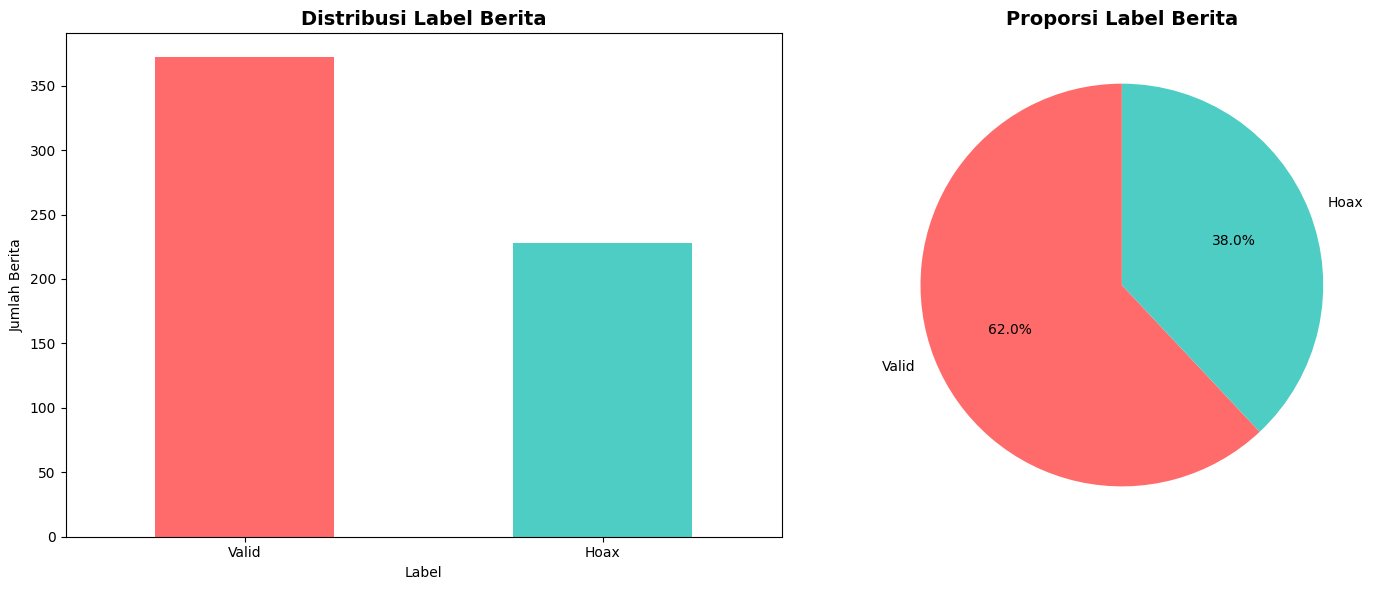


Class imbalance ratio: 0.613
⚠️  Dataset memiliki class imbalance yang signifikan


In [12]:
# Analisis distribusi label
print("=== TARGET DISTRIBUTION ===")
label_counts = df['tagging'].value_counts()
print(label_counts)
print(f"\nPercentage distribution:")
label_pct = df['tagging'].value_counts(normalize=True) * 100
print(label_pct)

# Visualisasi distribusi label
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot
label_counts.plot(kind='bar', ax=ax1, color=['#FF6B6B', '#4ECDC4'])
ax1.set_title('Distribusi Label Berita', fontsize=14, fontweight='bold')
ax1.set_xlabel('Label')
ax1.set_ylabel('Jumlah Berita')
ax1.tick_params(axis='x', rotation=0)

# Pie chart
ax2.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%',
        colors=['#FF6B6B', '#4ECDC4'], startangle=90)
ax2.set_title('Proporsi Label Berita', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Cek class imbalance
imbalance_ratio = label_counts.min() / label_counts.max()
print(f"\nClass imbalance ratio: {imbalance_ratio:.3f}")
if imbalance_ratio < 0.8:
    print("⚠️  Dataset memiliki class imbalance yang signifikan")
else:
    print("✅ Dataset relatif seimbang")

### Analisis Target Variable
- **Class Distribution**: Menunjukkan proporsi berita Valid vs Hoax dalam dataset
- **Class Imbalance**: Rasio ketidakseimbangan kelas yang dapat mempengaruhi performa model
- **Handling Strategy**: Jika terdapat imbalance signifikan, pertimbangkan teknik sampling atau cost-sensitive learning

### Handling Imbalance Data

In [13]:
# ===============================
# CONFIG
# ===============================
BASE_HOAX = "https://turnbackhoax.id/"
BASE_VALID = "https://nasional.sindonews.com/more/5"
HEADERS = {"User-Agent": "Mozilla/5.0"}
MAX_RETRIES = 5
TARGET_VALID = 550
TARGET_HOAX = 550

# ===============================
# Helpers
# ===============================
def fetch_soup(url):
    r = requests.get(url, headers=HEADERS, timeout=20)
    r.raise_for_status()
    return BeautifulSoup(r.text, "html.parser")

def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return None
    text = unicodedata.normalize("NFKC", text)
    text = re.sub(r"[^A-Za-z0-9.,!?()/%:;\-\s]", " ", text)
    text = re.sub(r"(?<=\s)[a-zA-Z](?=\s)", " ", text)
    text = re.sub(r"[.!?]{2,}", lambda m: m.group(0)[0], text)
    text = re.sub(r"\s+", " ", text).strip()
    return text if len(text) >= 5 else None

def get_needed_counts(df):
    current_valid = df[df["tagging"] == "Valid"].shape[0]
    current_hoax = df[df["tagging"] == "Hoax"].shape[0]
    needed_valid = max(0, TARGET_VALID - current_valid)
    needed_hoax = max(0, TARGET_HOAX - current_hoax)
    return needed_valid, needed_hoax

# ===============================
# Hoax Scraper
# ===============================
def extract_article_text(url):
    for attempt in range(MAX_RETRIES):
        try:
            soup = fetch_soup(url)
            blockquote = soup.find("blockquote")
            if blockquote:
                texts = [p.get_text(strip=True) for p in blockquote.find_all("p")]
                if texts:
                    return clean_text(" ".join(texts))
            return None
        except Exception:
            time.sleep(1)
    return None

def scrape_hoax(n_items, existing_urls=None):
    if existing_urls is None:
        existing_urls = set()

    collected, seen, page = [], set(), 1
    while len(collected) < n_items:
        url = BASE_HOAX if page == 1 else f"{BASE_HOAX}page/{page}/"
        try:
            soup = fetch_soup(url)
        except Exception:
            page += 1
            continue

        articles = soup.select("div#main-content article.mh-loop-item")
        if not articles:
            break

        for article in articles:
            if len(collected) >= n_items:
                break

            link_tag = article.select_one("h3.entry-title a")
            if not link_tag:
                continue

            article_url = link_tag.get("href")
            if not article_url or article_url in seen or article_url in existing_urls:
                continue
            seen.add(article_url)

            text = extract_article_text(article_url)
            if text:
                collected.append({"berita": text, "tagging": "Hoax", "url": article_url})
                existing_urls.add(article_url)

            time.sleep(0.2)

        page += 1

    return pd.DataFrame(collected)

# ===============================
# Sindonews Valid Scraper
# ===============================
def extract_first_paragraph(url):
    for attempt in range(MAX_RETRIES):
        try:
            soup = fetch_soup(url)
            detail = soup.find("div", id="detail-desc")

            if detail:
                for tag in detail(["a", "iframe", "script"]):
                    tag.unwrap()

                raw_html = str(detail)
                parts = re.split(r"<br\s*/?>\s*<br\s*/?>", raw_html, maxsplit=1)
                first_block = BeautifulSoup(parts[0], "html.parser").get_text(" ", strip=True)

                if "–" in first_block:
                    first_block = first_block.split("–", 1)[1].strip()
                elif "—" in first_block:
                    first_block = first_block.split("—", 1)[1].strip()

                cleaned = clean_text(first_block)
                if cleaned:
                    return cleaned

        except Exception as e:
            print("Error extracting:", e)
            time.sleep(1)

    return None


def _find_link_in_listarticle(article_tag):
    """Get article link from .list-article blocks"""
    a = article_tag.find("a", href=True)
    if a:
        return a["href"].strip()
    return None


def scrape_valid(n_items, existing_urls=None):
    if existing_urls is None:
        existing_urls = set()

    collected = []
    page_url = BASE_VALID
    failed_urls = []

    while len(collected) < n_items and page_url:
        soup = fetch_soup(page_url)
        articles = soup.find_all("div", class_="list-article")
        if not articles:
            break

        for art in articles:
            if len(collected) >= n_items:
                break

            url = _find_link_in_listarticle(art)
            if not url or url in existing_urls:
                continue

            text = extract_first_paragraph(url)
            if text:
                collected.append({"berita": text, "tagging": "Valid", "url": url})
                existing_urls.add(url)
            else:
                failed_urls.append(url)

            time.sleep(0.3)

        # pagination (if exists)
        next_btn = soup.find("a", rel="next") or soup.find("a", class_="next")
        page_url = urljoin(BASE_VALID, next_btn["href"]) if next_btn else None

    return pd.DataFrame(collected)


# ===============================
# Update Dataset
# ===============================
def update_dataset(df):
    existing_urls = set(df.get("url", []))
    needed_valid, needed_hoax = get_needed_counts(df)

    hoax_df = scrape_hoax(n_items=needed_hoax, existing_urls=existing_urls)
    valid_df = scrape_valid(n_items=needed_valid, existing_urls=existing_urls)

    print(f"Scraped {len(hoax_df)} Hoax samples, {len(valid_df)} Valid samples")

    df = pd.concat([df, hoax_df, valid_df], ignore_index=True)
    return df

In [14]:
# Update dataset
df = update_dataset(df)

# Show counts after update
print("\n🔎 Tagging counts after update:")
print(df['tagging'].value_counts())

Scraped 322 Hoax samples, 178 Valid samples

🔎 Tagging counts after update:
tagging
Valid    550
Hoax     550
Name: count, dtype: int64


In [15]:
duplicates = df[df.duplicated()]

# Print duplicate rows
print("Number of duplicate rows:", duplicates.shape[0])
print(duplicates)

Number of duplicate rows: 0
Empty DataFrame
Columns: [berita, tagging, url]
Index: []


### 4. Text Length Analysis

In [16]:
# Analisis panjang teks
df['text_length'] = df['berita'].str.len()
df['word_count'] = df['berita'].str.split().str.len()
df['sentence_count'] = df['berita'].str.split('.').str.len()

print("=== TEXT LENGTH STATISTICS ===")
print("Character Length:")
print(df.groupby('tagging')['text_length'].describe())

print("\nWord Count:")
print(df.groupby('tagging')['word_count'].describe())

print("\nSentence Count:")
print(df.groupby('tagging')['sentence_count'].describe())

=== TEXT LENGTH STATISTICS ===
Character Length:
         count         mean          std   min    25%     50%      75%     max
tagging                                                                       
Hoax     550.0  1111.000000  1356.549310  12.0  139.0   398.5  1768.25  8570.0
Valid    550.0  1516.234545  1264.410171  14.0  309.0  1339.5  2144.25  9618.0

Word Count:
         count        mean         std  min    25%    50%     75%     max
tagging                                                                  
Hoax     550.0  157.065455  191.934385  2.0  20.25   57.0  247.75  1245.0
Valid    550.0  211.843636  176.483484  2.0  43.25  188.5  299.50  1263.0

Sentence Count:
         count       mean        std  min  25%   50%   75%    max
tagging                                                          
Hoax     550.0   9.725455  12.255146  1.0  1.0   4.0  15.0   77.0
Valid    550.0  13.498182  12.660877  1.0  3.0  12.0  20.0  132.0


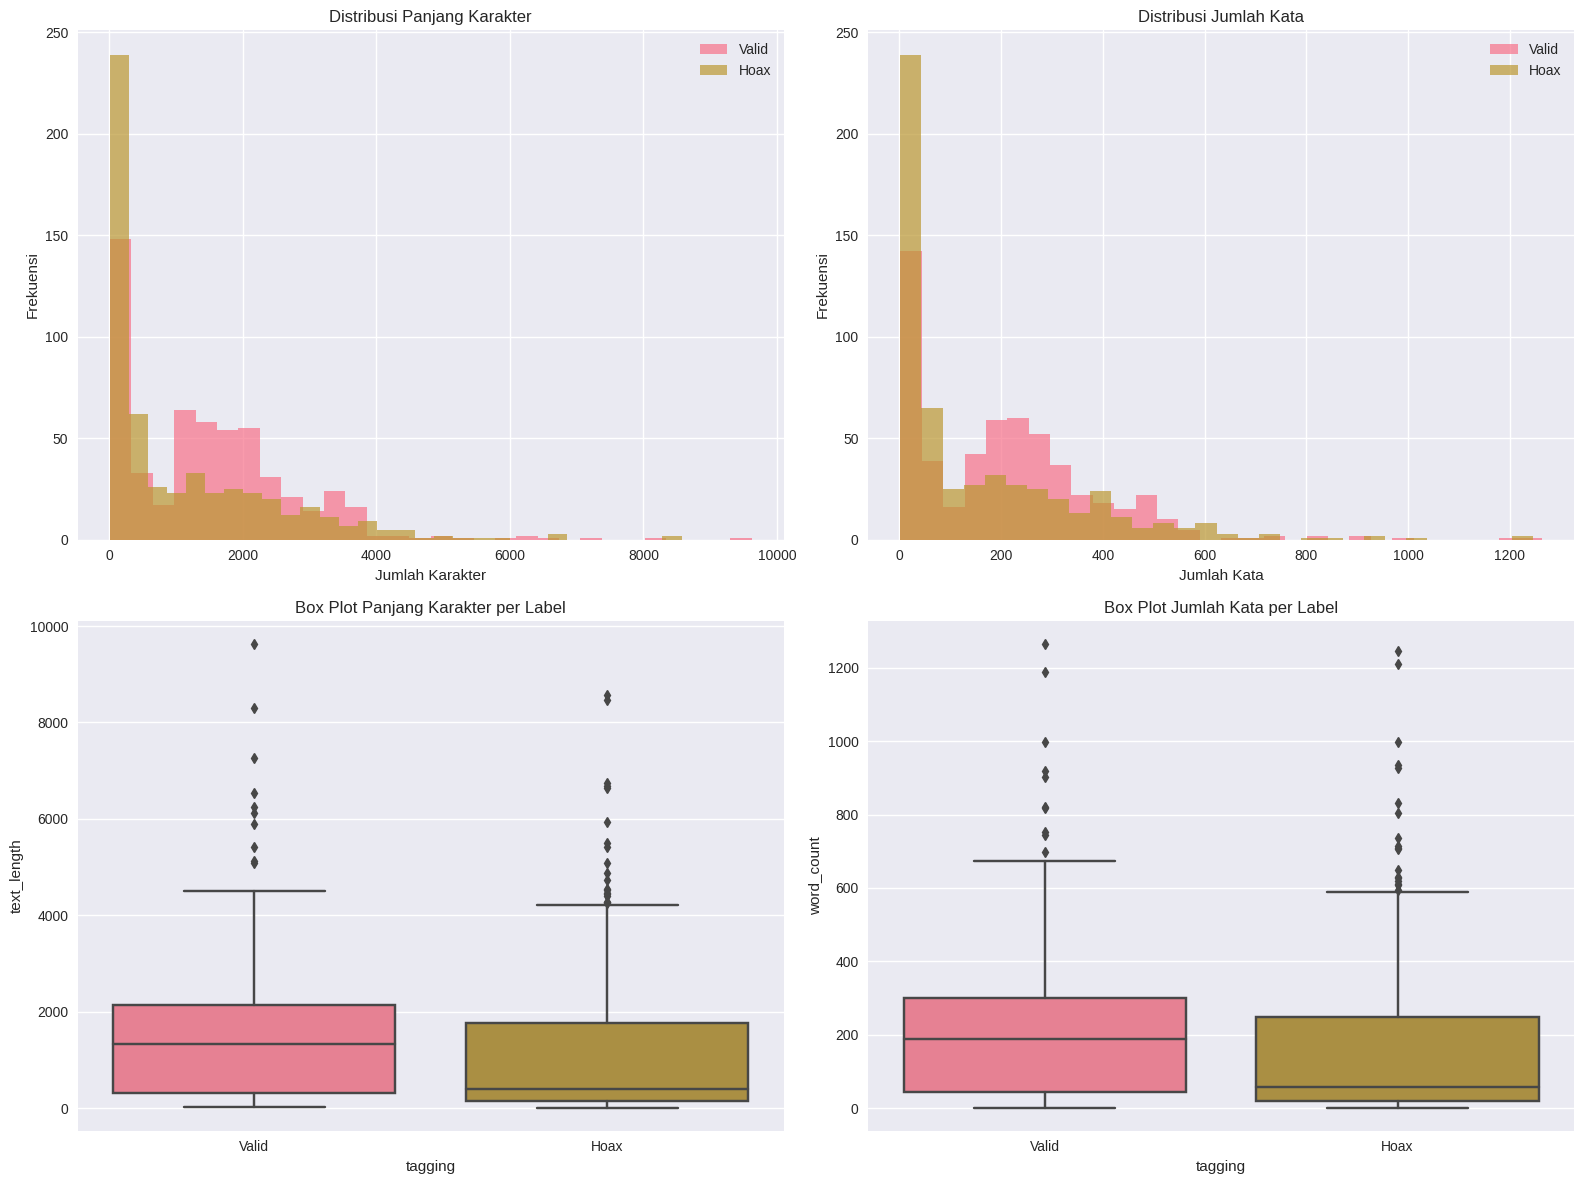

In [17]:
# Setting untuk visualisasi
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')
# Konfigurasi matplotlib untuk font Indonesia
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (12, 8)

# Visualisasi distribusi panjang teks
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Character length distribution
for label in df['tagging'].unique():
    data = df[df['tagging'] == label]['text_length']
    axes[0,0].hist(data, alpha=0.7, label=label, bins=30)
axes[0,0].set_title('Distribusi Panjang Karakter')
axes[0,0].set_xlabel('Jumlah Karakter')
axes[0,0].set_ylabel('Frekuensi')
axes[0,0].legend()

# Word count distribution
for label in df['tagging'].unique():
    data = df[df['tagging'] == label]['word_count']
    axes[0,1].hist(data, alpha=0.7, label=label, bins=30)
axes[0,1].set_title('Distribusi Jumlah Kata')
axes[0,1].set_xlabel('Jumlah Kata')
axes[0,1].set_ylabel('Frekuensi')
axes[0,1].legend()

# Box plot for character length
sns.boxplot(data=df, x='tagging', y='text_length', ax=axes[1,0])
axes[1,0].set_title('Box Plot Panjang Karakter per Label')

# Box plot for word count
sns.boxplot(data=df, x='tagging', y='word_count', ax=axes[1,1])
axes[1,1].set_title('Box Plot Jumlah Kata per Label')

plt.tight_layout()
plt.show()

### Analisis Panjang Teks
- **Character/Word Distribution**: Menunjukkan pola panjang teks antara berita Valid dan Hoax
- **Statistical Differences**: Perbedaan rata-rata panjang teks dapat menjadi feature yang berguna
- **Outliers**: Teks yang terlalu pendek atau panjang mungkin perlu penanganan khusus

### 5. Text Content Analysis

In [18]:
# Fungsi untuk text preprocessing
def basic_preprocessing(text):
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Preprocessing untuk analisis
df['cleaned_text'] = df['berita'].apply(basic_preprocessing)

# Analisis kata yang paling sering muncul
def get_top_words(texts, n=20):
    all_words = []
    for text in texts:
        all_words.extend(text.split())
    return Counter(all_words).most_common(n)

print("=== TOP WORDS ANALYSIS ===")
for label in df['tagging'].unique():
    print(f"\nTop 15 words in {label} news:")
    label_texts = df[df['tagging'] == label]['cleaned_text']
    top_words = get_top_words(label_texts, 15)
    for word, count in top_words:
        print(f"{word}: {count}")

=== TOP WORDS ANALYSIS ===

Top 15 words in Valid news:
yang: 3557
dan: 2334
di: 2310
ini: 1212
dari: 1174
itu: 1172
tidak: 1120
tersebut: 1014
dengan: 938
dalam: 916
untuk: 820
ada: 812
pada: 748
lele: 599
bahwa: 568

Top 15 words in Hoax news:
yang: 2570
dan: 1707
di: 1649
ini: 928
dari: 925
dengan: 776
tidak: 732
untuk: 717
itu: 700
dalam: 679
tersebut: 644
lele: 482
ada: 481
ikan: 467
juga: 443


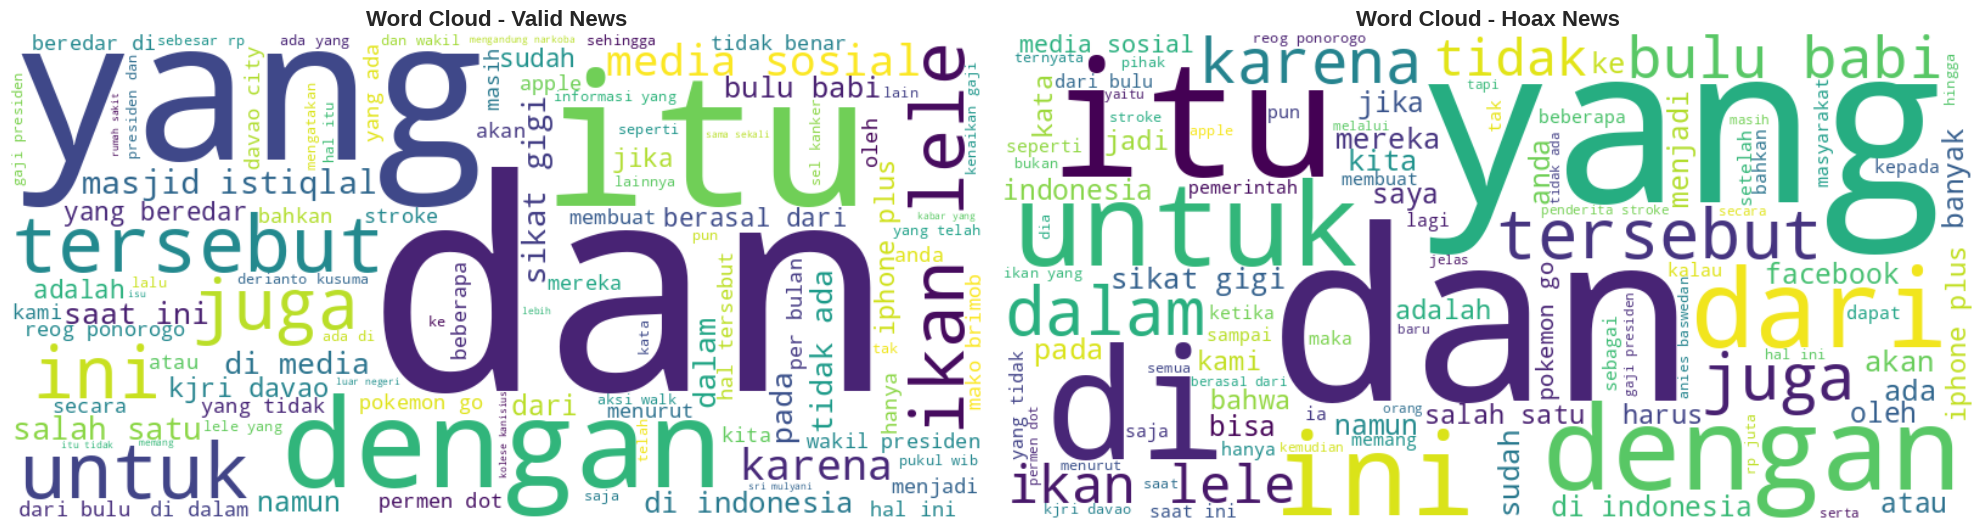

In [19]:
# Word Cloud untuk setiap label
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

for idx, label in enumerate(df['tagging'].unique()):
    label_texts = df[df['tagging'] == label]['cleaned_text']
    text_combined = ' '.join(label_texts)

    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         max_words=100,
                         colormap='viridis').generate(text_combined)

    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Word Cloud - {label} News', fontsize=16, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### Analisis Konten Teks
- **Top Words**: Identifikasi kata-kata yang paling sering muncul di setiap kategori
- **Word Cloud**: Visualisasi kata-kata dominan membantu memahami tema utama
- **Distinctive Features**: Kata-kata unik untuk setiap kategori dapat menjadi feature penting untuk klasifikasi

### 6. Advanced Text Features Analysis

In [20]:
# Analisis fitur teks lanjutan
def extract_text_features(text):
    features = {}

    # Basic counts
    features['char_count'] = len(text)
    features['word_count'] = len(text.split())
    features['sentence_count'] = len(text.split('.'))

    # Punctuation analysis
    features['exclamation_count'] = text.count('!')
    features['question_count'] = text.count('?')
    features['uppercase_count'] = sum(1 for c in text if c.isupper())

    # Number analysis
    features['number_count'] = len(re.findall(r'\d+', text))

    # Average word length
    words = text.split()
    if words:
        features['avg_word_length'] = np.mean([len(word) for word in words])
    else:
        features['avg_word_length'] = 0

    return features

# Extract features untuk semua teks
text_features = df['berita'].apply(extract_text_features)
feature_df = pd.DataFrame(list(text_features))
feature_df['tagging'] = df['tagging']

# Statistik fitur per label
print("=== ADVANCED TEXT FEATURES ===")
for feature in ['exclamation_count', 'question_count', 'uppercase_count', 'number_count', 'avg_word_length']:
    print(f"\n{feature.upper()}:")
    print(feature_df.groupby('tagging')[feature].describe())

=== ADVANCED TEXT FEATURES ===

EXCLAMATION_COUNT:
         count      mean       std  min  25%  50%  75%   max
tagging                                                     
Hoax     550.0  0.221818  0.794950  0.0  0.0  0.0  0.0  11.0
Valid    550.0  0.029091  0.223951  0.0  0.0  0.0  0.0   4.0

QUESTION_COUNT:
         count      mean       std  min  25%  50%  75%   max
tagging                                                     
Hoax     550.0  0.340000  1.221707  0.0  0.0  0.0  0.0  20.0
Valid    550.0  0.318182  0.983765  0.0  0.0  0.0  0.0   9.0

UPPERCASE_COUNT:
         count       mean        std  min    25%   50%   75%    max
tagging                                                            
Hoax     550.0  63.130909  79.499763  0.0  13.00  41.5  84.0  639.0
Valid    550.0  58.601818  41.997220  1.0  29.25  47.0  77.0  376.0

NUMBER_COUNT:
         count      mean       std  min  25%  50%  75%   max
tagging                                                     
Hoax     550.0  4

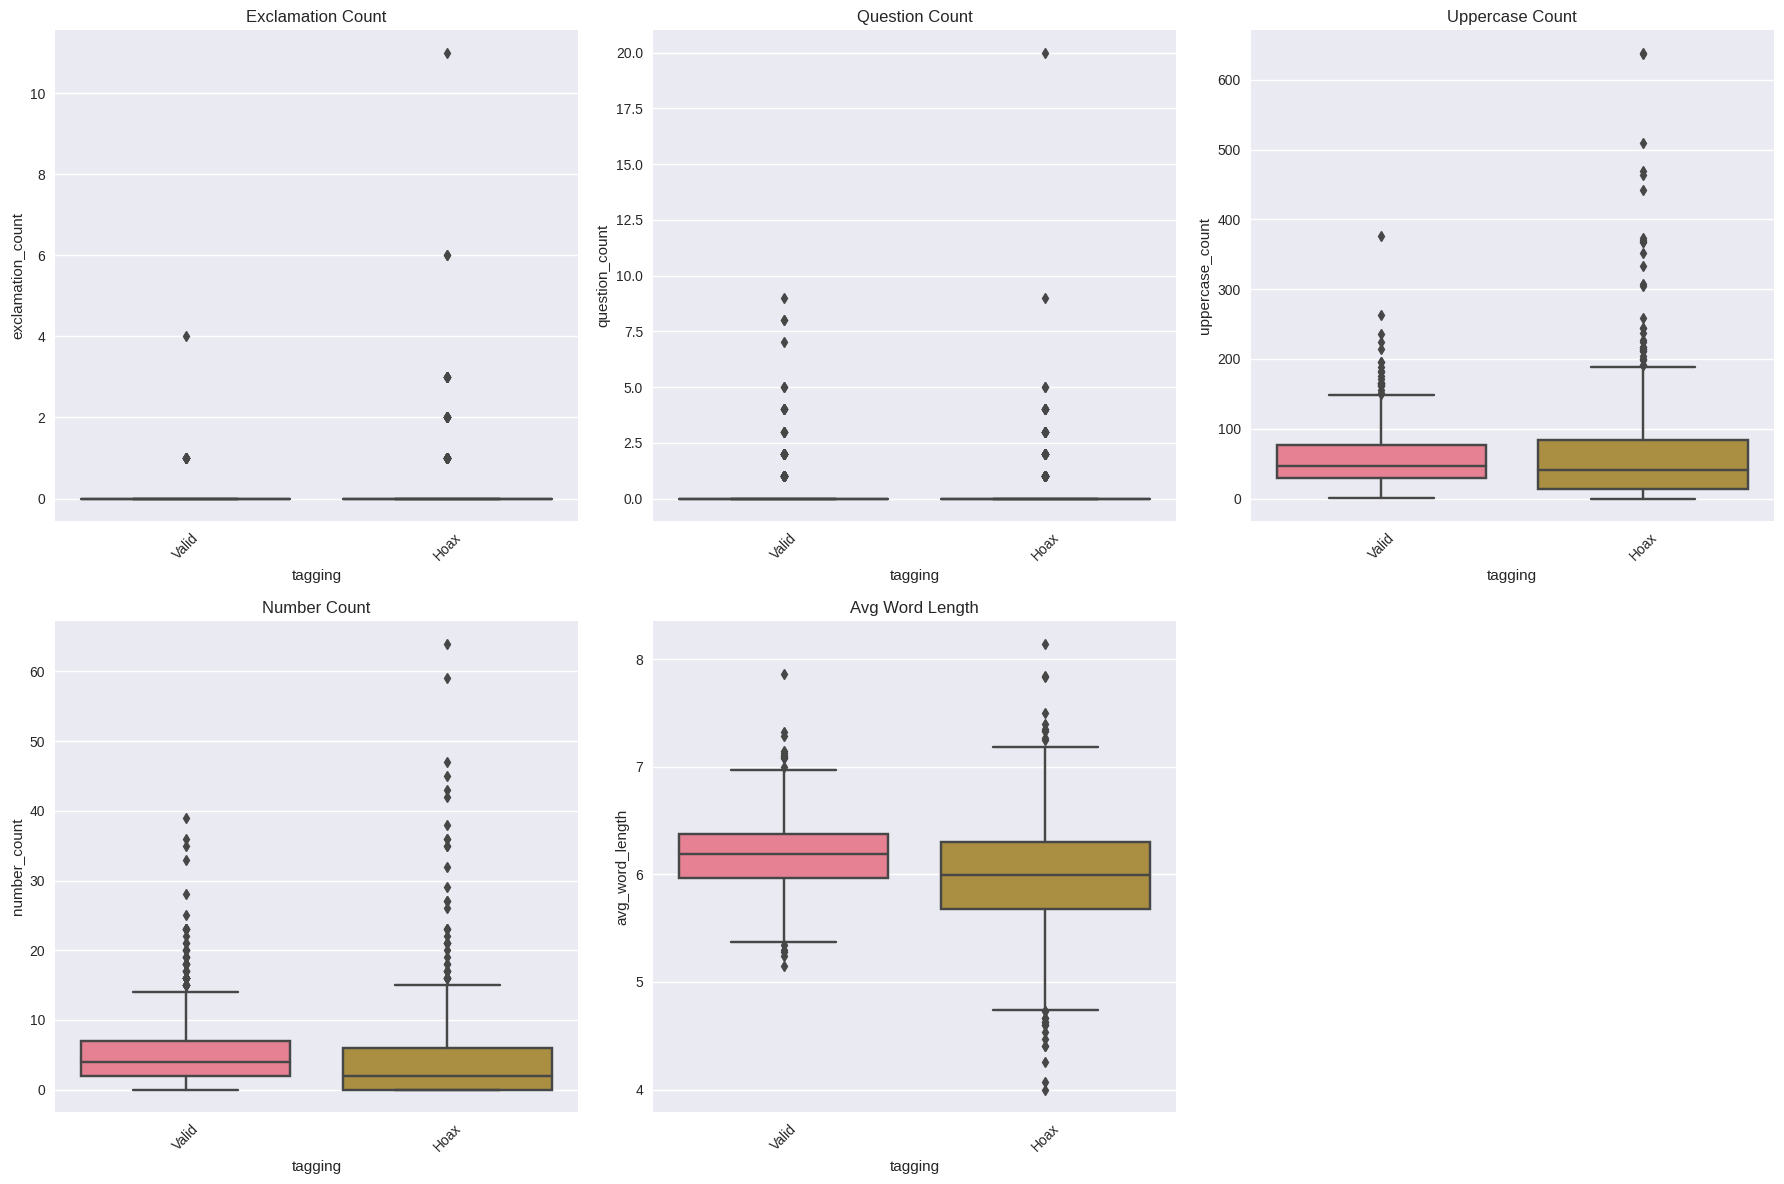

In [21]:
# Visualisasi fitur teks lanjutan
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

features_to_plot = ['exclamation_count', 'question_count', 'uppercase_count', 'number_count', 'avg_word_length']

for idx, feature in enumerate(features_to_plot):
    sns.boxplot(data=feature_df, x='tagging', y=feature, ax=axes[idx])
    axes[idx].set_title(f'{feature.replace("_", " ").title()}')
    axes[idx].tick_params(axis='x', rotation=45)

# Remove empty subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

### Analisis Fitur Teks Lanjutan
- **Punctuation Patterns**: Penggunaan tanda baca dapat mengindikasikan emotional tone
- **Uppercase Usage**: Banyaknya huruf kapital mungkin menunjukkan sensationalism
- **Number Usage**: Frekuensi angka dalam teks bisa menjadi indicator kredibilitas
- **Word Length**: Rata-rata panjang kata dapat menunjukkan kompleksitas bahasa

### 7. Keyword and Pattern Analysis

In [22]:
# Analisis keyword yang sering muncul di hoax
suspicious_keywords = [
    'viral', 'heboh', 'mengejutkan', 'menakjubkan', 'terungkap',
    'rahasia', 'fakta', 'sebenarnya', 'ternyata', 'breaking news',
    'waspada', 'hati hati', 'awas', 'jangan', 'bahaya'
]

# Hitung kemunculan keyword suspicious
def count_suspicious_words(text):
    text_lower = text.lower()
    count = 0
    found_words = []
    for keyword in suspicious_keywords:
        if keyword in text_lower:
            count += text_lower.count(keyword)
            found_words.append(keyword)
    return count, found_words

df['suspicious_word_count'] = df['berita'].apply(lambda x: count_suspicious_words(x)[0])
df['suspicious_words'] = df['berita'].apply(lambda x: count_suspicious_words(x)[1])

print("=== SUSPICIOUS KEYWORDS ANALYSIS ===")
print("Average suspicious word count per label:")
print(df.groupby('tagging')['suspicious_word_count'].mean())

print("\nDistribution of suspicious word counts:")
print(df.groupby('tagging')['suspicious_word_count'].describe())

=== SUSPICIOUS KEYWORDS ANALYSIS ===
Average suspicious word count per label:
tagging
Hoax     0.961818
Valid    1.069091
Name: suspicious_word_count, dtype: float64

Distribution of suspicious word counts:
         count      mean       std  min  25%  50%  75%   max
tagging                                                     
Hoax     550.0  0.961818  1.783449  0.0  0.0  0.0  1.0  13.0
Valid    550.0  1.069091  1.853159  0.0  0.0  0.0  1.0  12.0


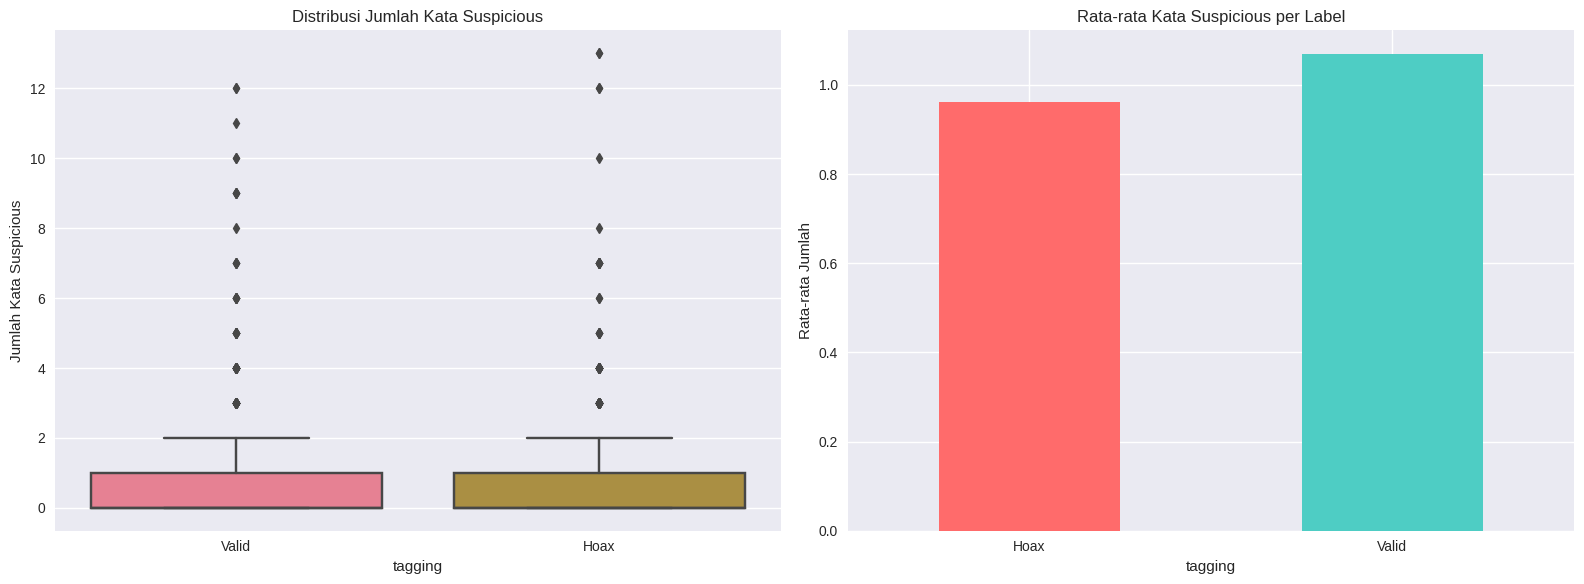


=== MOST FREQUENT SUSPICIOUS WORDS ===
Top 10 suspicious words found:
jangan: 132
bahaya: 116
ternyata: 111
viral: 77
sebenarnya: 77
waspada: 59
fakta: 52
awas: 50
heboh: 36
terungkap: 28


In [23]:
# Visualisasi suspicious keywords
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot
sns.boxplot(data=df, x='tagging', y='suspicious_word_count', ax=axes[0])
axes[0].set_title('Distribusi Jumlah Kata Suspicious')
axes[0].set_ylabel('Jumlah Kata Suspicious')

# Bar plot rata-rata
suspicious_mean = df.groupby('tagging')['suspicious_word_count'].mean()
suspicious_mean.plot(kind='bar', ax=axes[1], color=['#FF6B6B', '#4ECDC4'])
axes[1].set_title('Rata-rata Kata Suspicious per Label')
axes[1].set_ylabel('Rata-rata Jumlah')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Analisis kata-kata suspicious yang paling sering
print("\n=== MOST FREQUENT SUSPICIOUS WORDS ===")
all_suspicious = []
for words_list in df['suspicious_words']:
    all_suspicious.extend(words_list)

suspicious_counter = Counter(all_suspicious)
print("Top 10 suspicious words found:")
for word, count in suspicious_counter.most_common(10):
    print(f"{word}: {count}")

### Analisis Keyword dan Pola
- **Suspicious Keywords**: Kata-kata yang umumnya digunakan dalam clickbait atau hoax
- **Pattern Recognition**: Identifikasi pola linguistik yang membedakan berita valid dan hoax
- **Feature Engineering**: Hasil analisis ini dapat digunakan sebagai feature untuk model ML

### 8. Correlation Analysis

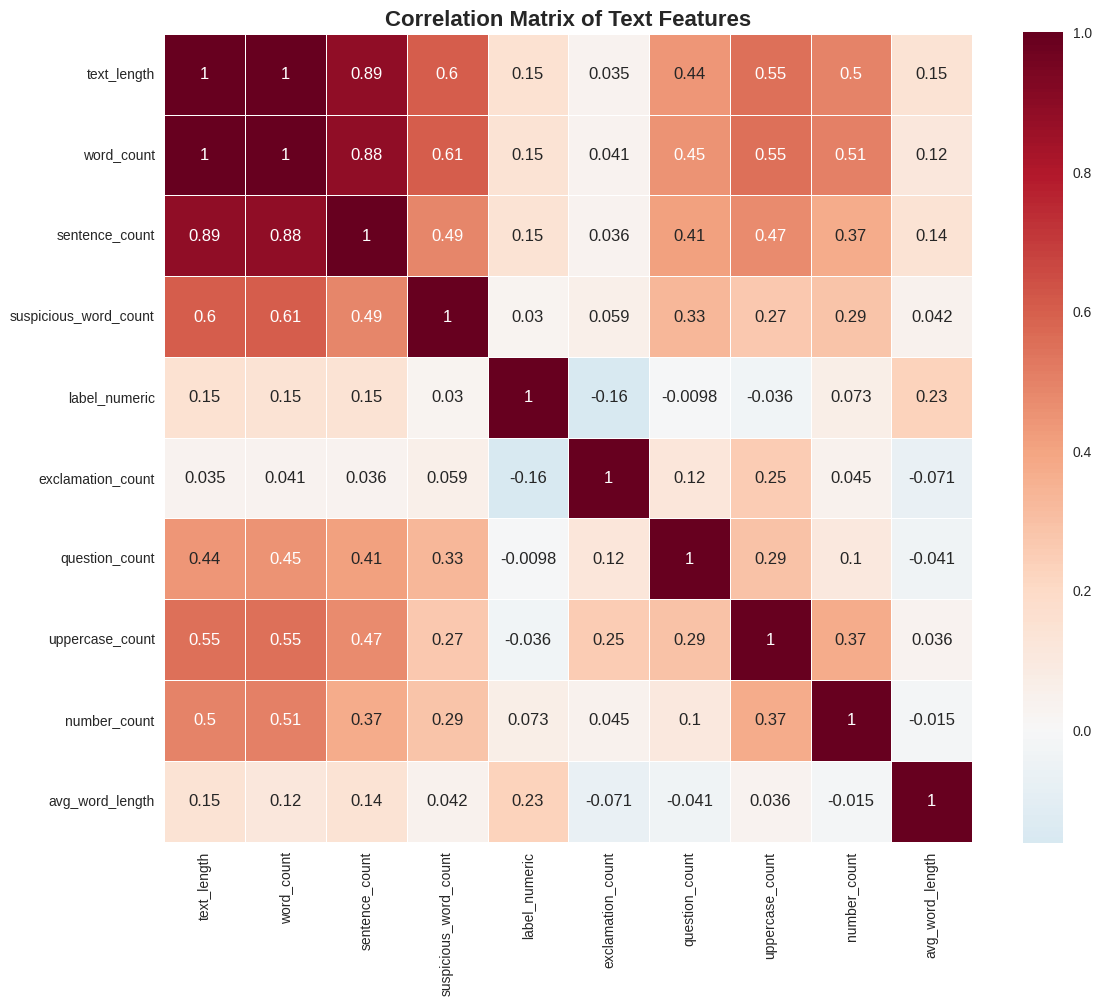

=== FEATURE CORRELATION WITH LABEL ===
Features ranked by absolute correlation with label:
avg_word_length: 0.2348
exclamation_count: 0.1630
text_length: 0.1528
sentence_count: 0.1498
word_count: 0.1471
number_count: 0.0728
uppercase_count: 0.0356
suspicious_word_count: 0.0295
question_count: 0.0098


In [24]:
# Membuat dataset untuk analisis korelasi
# Convert tagging ke numerik (0: Hoax, 1: Valid)
df['label_numeric'] = df['tagging'].map({'Hoax': 0, 'Valid': 1})

# Combine all numeric features
corr_features = [
    'text_length', 'word_count', 'sentence_count',
    'suspicious_word_count', 'label_numeric'
]

# Add features from feature_df
for feature in ['exclamation_count', 'question_count', 'uppercase_count', 'number_count', 'avg_word_length']:
    df[feature] = feature_df[feature]
    corr_features.append(feature)

# Correlation matrix
corr_matrix = df[corr_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Text Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Feature importance berdasarkan korelasi dengan label
feature_corr = corr_matrix['label_numeric'].abs().sort_values(ascending=False)
print("=== FEATURE CORRELATION WITH LABEL ===")
print("Features ranked by absolute correlation with label:")
for feature, corr in feature_corr.items():
    if feature != 'label_numeric':
        print(f"{feature}: {corr:.4f}")

### Analisis Korelasi
- **Feature Relationships**: Memahami hubungan antar fitur teks
- **Target Correlation**: Identifikasi fitur yang paling berkorelasi dengan label
- **Multicollinearity**: Deteksi fitur yang saling berkorelasi tinggi untuk feature selection

### 9. Sample Analysis

In [25]:
# Analisis sampel teks
print("=== SAMPLE TEXT ANALYSIS ===")

print("\n📰 CONTOH BERITA VALID:")
valid_samples = df[df['tagging'] == 'Valid']['berita'].head(3)
for i, text in enumerate(valid_samples, 1):
    print(f"\nSample {i}:")
    print(f"Length: {len(text)} characters")
    print(f"Text: {text[:200]}..." if len(text) > 200 else f"Text: {text}")

print("\n🚨 CONTOH BERITA HOAX:")
hoax_samples = df[df['tagging'] == 'Hoax']['berita'].head(3)
for i, text in enumerate(hoax_samples, 1):
    print(f"\nSample {i}:")
    print(f"Length: {len(text)} characters")
    print(f"Text: {text[:200]}..." if len(text) > 200 else f"Text: {text}")

=== SAMPLE TEXT ANALYSIS ===

📰 CONTOH BERITA VALID:

Sample 1:
Length: 1999 characters
Text: Jakarta, Di jejaring sosial, banyak beredar informasi yang menyebut lele sebagai ikan paling jorok. Dalam sesuap daging ikan lele, terkandung 3000 sel kanker. Benarkah? Julukan sebagai ikan paling jor...

Sample 2:
Length: 2858 characters
Text: Isu bahwa ikan lele mengandung sel kanker di jejaring social dan berita dari mulut ke mulut terus menyebar. Dampak dari isu tersebut para ibu ibu enggan membeli ikan lele. Waspada Online berhasil mera...

Sample 3:
Length: 1722 characters
Text: Bagi penikmat kuliner dengan bahan dasar ikan lele, berita ini sungguh sangat menyedihkan, bagaimana tidak, ikan yang selama ini sangat enak ini dianggap sebagai sumber penyakit . Beberapa informasi y...

🚨 CONTOH BERITA HOAX:

Sample 1:
Length: 3003 characters
Text: "Dalam sesuap daging ikan lele, terkandung 3.000 sel kanker". Judul artikel tersebut beberapa hari terakhir menjadi pembicaraan hangat di media sosi

### Analisis Sampel
- **Qualitative Analysis**: Pemahaman kualitatif tentang perbedaan gaya penulisan
- **Pattern Recognition**: Identifikasi pola manual yang mungkin terlewat dalam analisis kuantitatif
- **Domain Understanding**: Membangun intuisi untuk feature engineering dan model selection

### 10. Summary dan Insights

In [27]:
# Summary statistics
print("=== EDA SUMMARY ===")
print(f"📊 Dataset Size: {len(df):,} samples")
print(f"📈 Features Analyzed: {len(corr_features)} text features")
print(f"⚖️ Class Balance: {df['tagging'].value_counts().to_dict()}")

# Key findings
print("\n=== KEY FINDINGS ===")

# 1. Text length differences
valid_avg_length = df[df['tagging'] == 'Valid']['text_length'].mean()
hoax_avg_length = df[df['tagging'] == 'Hoax']['text_length'].mean()
print(f"\n1. 📝 TEXT LENGTH:")
print(f"   - Valid news average: {valid_avg_length:.0f} characters")
print(f"   - Hoax news average: {hoax_avg_length:.0f} characters")
print(f"   - Difference: {abs(valid_avg_length - hoax_avg_length):.0f} characters")

# 2. Suspicious words
valid_suspicious = df[df['tagging'] == 'Valid']['suspicious_word_count'].mean()
hoax_suspicious = df[df['tagging'] == 'Hoax']['suspicious_word_count'].mean()
print(f"\n2. 🚨 SUSPICIOUS KEYWORDS:")
print(f"   - Valid news average: {valid_suspicious:.2f} suspicious words")
print(f"   - Hoax news average: {hoax_suspicious:.2f} suspicious words")
print(f"   - Difference: {abs(valid_suspicious - hoax_suspicious):.2f}")

# 3. Top correlated features
print(f"\n3. 🎯 TOP FEATURES FOR CLASSIFICATION:")
top_features = feature_corr.head(4).index.tolist()
for feature in top_features:
    if feature != 'label_numeric':
        print(f"   - {feature}: {feature_corr[feature]:.4f} correlation")

=== EDA SUMMARY ===
📊 Dataset Size: 1,100 samples
📈 Features Analyzed: 10 text features
⚖️ Class Balance: {'Valid': 550, 'Hoax': 550}

=== KEY FINDINGS ===

1. 📝 TEXT LENGTH:
   - Valid news average: 1516 characters
   - Hoax news average: 1111 characters
   - Difference: 405 characters

2. 🚨 SUSPICIOUS KEYWORDS:
   - Valid news average: 1.07 suspicious words
   - Hoax news average: 0.96 suspicious words
   - Difference: 0.11

3. 🎯 TOP FEATURES FOR CLASSIFICATION:
   - avg_word_length: 0.2348 correlation
   - exclamation_count: 0.1630 correlation
   - text_length: 0.1528 correlation


### 11. Advanced Linguistic Analysis

In [28]:
# Analisis linguistik lanjutan
import string
from collections import defaultdict

# Analisis penggunaan tanda baca
def analyze_punctuation(text):
    punct_counts = defaultdict(int)
    for char in text:
        if char in string.punctuation:
            punct_counts[char] += 1
    return dict(punct_counts)

# Analisis untuk setiap kategori
print("=== PUNCTUATION ANALYSIS ===")
for label in df['tagging'].unique():
    print(f"\n{label.upper()} NEWS PUNCTUATION PATTERNS:")
    label_texts = df[df['tagging'] == label]['berita']
    all_punct = defaultdict(int)

    for text in label_texts:
        punct_dict = analyze_punctuation(text)
        for punct, count in punct_dict.items():
            all_punct[punct] += count

    # Tampilkan 10 tanda baca terbanyak
    sorted_punct = sorted(all_punct.items(), key=lambda x: x[1], reverse=True)[:10]
    for punct, count in sorted_punct:
        print(f"  '{punct}': {count}")

=== PUNCTUATION ANALYSIS ===

VALID NEWS PUNCTUATION PATTERNS:
  ',': 7003
  '.': 6874
  '-': 1566
  '(': 1273
  ')': 1273
  '"': 1236
  '/': 738
  '?': 175
  ''': 153
  ':': 124

HOAX NEWS PUNCTUATION PATTERNS:
  ',': 5146
  '.': 4799
  '-': 1027
  ')': 575
  '(': 573
  '"': 555
  '/': 395
  '?': 187
  ':': 161
  '!': 122


In [29]:
# Analisis kompleksitas bahasa
def calculate_avg_sentence_length(text):
    sentences = [s.strip() for s in text.split('.') if s.strip()]
    if not sentences:
        return 0
    total_words = sum(len(sentence.split()) for sentence in sentences)
    return total_words / len(sentences)

def calculate_unique_word_ratio(text):
    words = text.lower().split()
    if not words:
        return 0
    return len(set(words)) / len(words)

# Hitung metrik kompleksitas
df['avg_sentence_length'] = df['berita'].apply(calculate_avg_sentence_length)
df['unique_word_ratio'] = df['berita'].apply(calculate_unique_word_ratio)

print("=== LANGUAGE COMPLEXITY ANALYSIS ===")
print("\nAverage Sentence Length:")
print(df.groupby('tagging')['avg_sentence_length'].describe())

print("\nUnique Word Ratio (vocabulary diversity):")
print(df.groupby('tagging')['unique_word_ratio'].describe())

=== LANGUAGE COMPLEXITY ANALYSIS ===

Average Sentence Length:
         count      mean        std  min        25%        50%        75%  \
tagging                                                                     
Hoax     550.0  26.55451  74.481025  2.0  12.000000  15.792857  20.748529   
Valid    550.0  26.47596  45.483971  2.0  14.446429  16.641429  19.648214   

           max  
tagging         
Hoax     997.0  
Valid    494.0  

Unique Word Ratio (vocabulary diversity):
         count      mean       std       min       25%       50%       75%  \
tagging                                                                      
Hoax     550.0  0.795421  0.158029  0.379310  0.662949  0.805839  0.938962   
Valid    550.0  0.741715  0.149278  0.429319  0.624222  0.698831  0.897035   

         max  
tagging       
Hoax     1.0  
Valid    1.0  


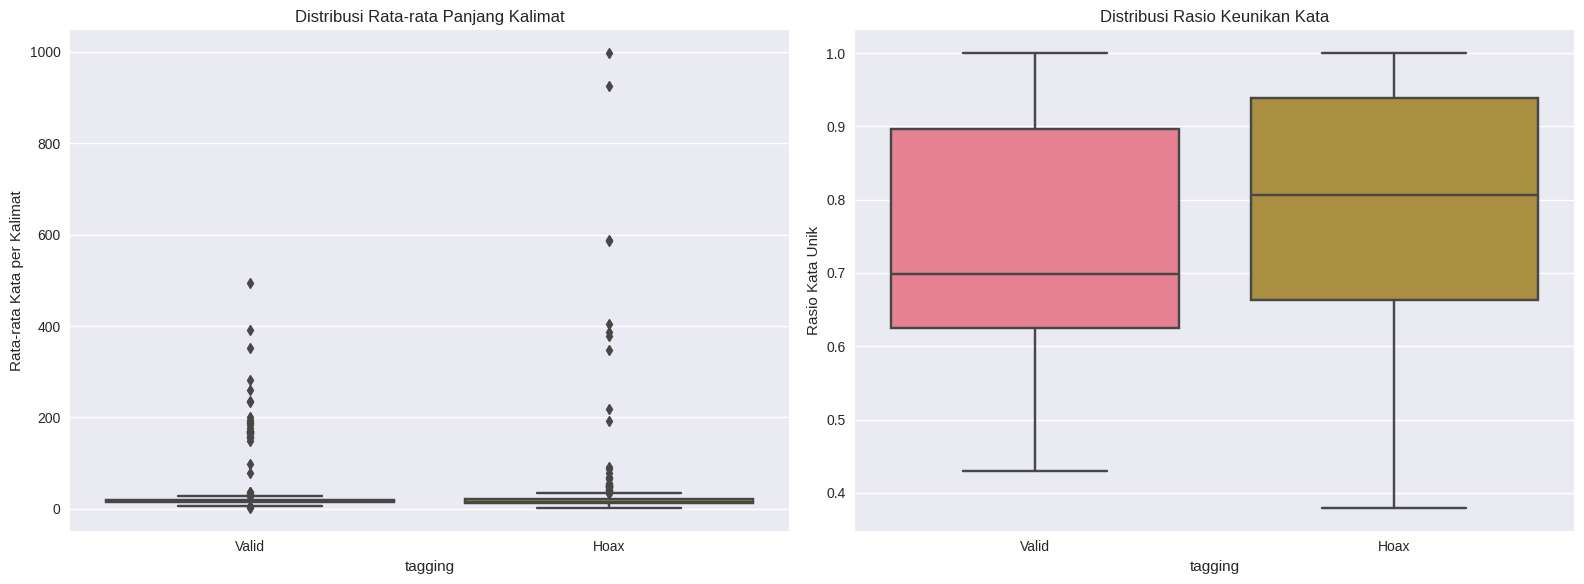

In [30]:
# Visualisasi kompleksitas bahasa
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Average sentence length
sns.boxplot(data=df, x='tagging', y='avg_sentence_length', ax=axes[0])
axes[0].set_title('Distribusi Rata-rata Panjang Kalimat')
axes[0].set_ylabel('Rata-rata Kata per Kalimat')

# Unique word ratio
sns.boxplot(data=df, x='tagging', y='unique_word_ratio', ax=axes[1])
axes[1].set_title('Distribusi Rasio Keunikan Kata')
axes[1].set_ylabel('Rasio Kata Unik')

plt.tight_layout()
plt.show()

### Analisis Linguistik Lanjutan
- **Punctuation Patterns**: Pola penggunaan tanda baca dapat mengindikasikan gaya penulisan
- **Sentence Complexity**: Panjang rata-rata kalimat menunjukkan kompleksitas struktur bahasa
- **Vocabulary Diversity**: Rasio kata unik menunjukkan kekayaan vocabulary yang digunakan

### 12. Temporal and URL Pattern Analysis

In [31]:
# Analisis pola URL dan link
def extract_url_features(text):
    # Pattern untuk mendeteksi URL
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    urls = re.findall(url_pattern, text)

    # Pattern untuk mendeteksi mention media sosial
    social_patterns = {
        'twitter': r'@\w+',
        'hashtag': r'#\w+',
        'facebook': r'facebook\.com',
        'instagram': r'instagram\.com',
        'youtube': r'youtube\.com|youtu\.be'
    }

    features = {
        'url_count': len(urls),
        'has_url': len(urls) > 0,
    }

    for platform, pattern in social_patterns.items():
        matches = re.findall(pattern, text, re.IGNORECASE)
        features[f'{platform}_count'] = len(matches)
        features[f'has_{platform}'] = len(matches) > 0

    return features

# Extract URL features
url_features = df['berita'].apply(extract_url_features)
url_df = pd.DataFrame(list(url_features))
url_df['tagging'] = df['tagging']

print("=== URL AND SOCIAL MEDIA PATTERN ANALYSIS ===")
print("\nURL Usage by Label:")
print(url_df.groupby('tagging')[['url_count', 'has_url']].agg(['mean', 'sum']))

print("\nSocial Media Mentions:")
social_cols = ['twitter_count', 'hashtag_count', 'facebook_count', 'instagram_count', 'youtube_count']
print(url_df.groupby('tagging')[social_cols].sum())

=== URL AND SOCIAL MEDIA PATTERN ANALYSIS ===

URL Usage by Label:
        url_count       has_url    
             mean sum      mean sum
tagging                            
Hoax     0.010909   6  0.009091   5
Valid    0.016364   9  0.007273   4

Social Media Mentions:
         twitter_count  hashtag_count  facebook_count  instagram_count  \
tagging                                                                  
Hoax                23             42               0                0   
Valid               24             59               0                0   

         youtube_count  
tagging                 
Hoax                 0  
Valid                0  


In [32]:
# Analisis pola waktu dan tanggal
def extract_time_patterns(text):
    # Pattern untuk mendeteksi tanggal dan waktu
    date_patterns = {
        'date_slash': r'\d{1,2}/\d{1,2}/\d{2,4}',  # 12/31/2023
        'date_dash': r'\d{1,2}-\d{1,2}-\d{2,4}',   # 12-31-2023
        'date_indo': r'\d{1,2}\s+(Januari|Februari|Maret|April|Mei|Juni|Juli|Agustus|September|Oktober|November|Desember)\s+\d{4}',
        'time_24': r'\d{1,2}:\d{2}',               # 14:30
        'year_mention': r'\b(19|20)\d{2}\b'        # 1999, 2023
    }

    features = {}
    for pattern_name, pattern in date_patterns.items():
        matches = re.findall(pattern, text, re.IGNORECASE)
        features[f'{pattern_name}_count'] = len(matches)
        features[f'has_{pattern_name}'] = len(matches) > 0

    return features

# Extract time patterns
time_features = df['berita'].apply(extract_time_patterns)
time_df = pd.DataFrame(list(time_features))
time_df['tagging'] = df['tagging']

print("\n=== TIME AND DATE PATTERN ANALYSIS ===")
print("\nDate/Time Pattern Usage:")
time_cols = ['date_slash_count', 'date_dash_count', 'date_indo_count', 'time_24_count', 'year_mention_count']
print(time_df.groupby('tagging')[time_cols].mean())


=== TIME AND DATE PATTERN ANALYSIS ===

Date/Time Pattern Usage:
         date_slash_count  date_dash_count  date_indo_count  time_24_count  \
tagging                                                                      
Hoax             0.134545         0.001818         0.118182       0.010909   
Valid            0.407273         0.000000         0.290909       0.007273   

         year_mention_count  
tagging                      
Hoax               0.558182  
Valid              1.118182  


### Analisis Pola Temporal dan URL
- **URL Patterns**: Frekuensi penggunaan link dapat mengindikasikan kredibilitas atau spam
- **Social Media References**: Mention platform media sosial menunjukkan sumber atau penyebaran
- **Time Patterns**: Penggunaan tanggal dan waktu spesifik dapat menunjukkan faktualitas

### 13. Final Feature Engineering Recommendations

In [34]:
# Compile semua fitur yang telah dianalisis
final_features = {
    'basic_stats': ['text_length', 'word_count', 'sentence_count'],
    'content_features': ['suspicious_word_count', 'exclamation_count', 'question_count', 'uppercase_count'],
    'complexity_features': ['avg_sentence_length', 'unique_word_ratio', 'avg_word_length'],
    'pattern_features': ['number_count']
}

# Combine all features untuk final dataset
feature_columns = []
for category, features in final_features.items():
    feature_columns.extend(features)

# Create final feature matrix
final_df = df[['berita', 'tagging'] + feature_columns].copy()

print("=== FINAL FEATURE ENGINEERING SUMMARY ===")
print(f"\n📊 Total Features Extracted: {len(feature_columns)}")
print(f"📈 Dataset Shape: {final_df.shape}")

print("\n🎯 FEATURE CATEGORIES:")
for category, features in final_features.items():
    print(f"\n{category.upper()}:")
    for feature in features:
        if feature in final_df.columns:
            corr_with_target = abs(df[[feature, 'label_numeric']].corr().iloc[0,1])
            print(f"  - {feature}: correlation = {corr_with_target:.4f}")

# Save processed dataset info
print(f"\n💾 PROCESSED DATA READY FOR ML:")
print(f"   - Shape: {final_df.shape}")
print(f"   - Features: {len(feature_columns)} numerical + text")
print(f"   - Classes: {final_df['tagging'].nunique()} (balanced: {final_df['tagging'].value_counts().min()/final_df['tagging'].value_counts().max():.2f})")
print(f"   - Ready for train/validation/test split")

=== FINAL FEATURE ENGINEERING SUMMARY ===

📊 Total Features Extracted: 11
📈 Dataset Shape: (1100, 13)

🎯 FEATURE CATEGORIES:

BASIC_STATS:
  - text_length: correlation = 0.1528
  - word_count: correlation = 0.1471
  - sentence_count: correlation = 0.1498

CONTENT_FEATURES:
  - suspicious_word_count: correlation = 0.0295
  - exclamation_count: correlation = 0.1630
  - question_count: correlation = 0.0098
  - uppercase_count: correlation = 0.0356

COMPLEXITY_FEATURES:
  - avg_sentence_length: correlation = 0.0006
  - unique_word_ratio: correlation = 0.1722
  - avg_word_length: correlation = 0.2348

PATTERN_FEATURES:
  - number_count: correlation = 0.0728

💾 PROCESSED DATA READY FOR ML:
   - Shape: (1100, 13)
   - Features: 11 numerical + text
   - Classes: 2 (balanced: 1.00)
   - Ready for train/validation/test split


In [35]:
train_df, test_df = train_test_split(final_df, test_size=0.2, random_state=SEED, stratify=df[LABEL_COL])
train_df, val_df  = train_test_split(train_df, test_size=0.2, random_state=SEED, stratify=train_df[LABEL_COL])

label2id = {l:i for i,l in enumerate(sorted(df[LABEL_COL].unique()))}
id2label = {i:l for l,i in label2id.items()}

print("Labels:", label2id)
for name, part in [("train", train_df), ("val", val_df), ("test", test_df)]:
    print(f"{name}: {part.shape}, label dist =\n", part[LABEL_COL].value_counts(normalize=True))

Labels: {'Hoax': 0, 'Valid': 1}
train: (704, 13), label dist =
 tagging
Hoax     0.5
Valid    0.5
Name: proportion, dtype: float64
val: (176, 13), label dist =
 tagging
Hoax     0.5
Valid    0.5
Name: proportion, dtype: float64
test: (220, 13), label dist =
 tagging
Hoax     0.5
Valid    0.5
Name: proportion, dtype: float64


# Hugging Face Datasets for Transformers

In [36]:
def to_hf(df_):
    return Dataset.from_pandas(pd.DataFrame({
        "text": df_[TEXT_COL].astype(str).tolist(),
        "label": df_[LABEL_COL].map(label2id).astype(int).tolist()
    }))

hf = DatasetDict({
    "train": to_hf(train_df),
    "validation": to_hf(val_df),
    "test": to_hf(test_df)
})
hf

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 704
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 176
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 220
    })
})

In [37]:
def build_tokenize_fn(model_name, max_length=512):
    tok = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    def _tok(examples):
        return tok(examples["text"], truncation=True, max_length=max_length)
    return tok, _tok

In [38]:
metric_acc = evaluate.load("accuracy")
metric_f1m = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": metric_acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": metric_f1m.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

def train_one_model_with_optuna(model_name, output_dir, num_labels, hf, id2label, label2id, collator, compute_metrics, n_trials=3):
    tokenizer, tokenize_fn = build_tokenize_fn(model_name)
    tokenized = hf.map(tokenize_fn, batched=True, remove_columns=["text"])
    def model_init():
        return AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels,
            id2label=id2label,
            label2id=label2id
        )
    def hp_space(trial):
        return {
            "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
            "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
            "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 3),
            "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
        }
    args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="no",
        report_to="none",
        disable_tqdm=True,
        seed=SEED,
    )
    trainer = Trainer(
        model_init=model_init,
        args=args,
        train_dataset=tokenized["train"],
        eval_dataset=tokenized["validation"],
        tokenizer=tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
    )
    best_run = trainer.hyperparameter_search(
        direction="maximize",
        hp_space=hp_space,
        n_trials=n_trials
    )
    print(f"Best hyperparameters for {model_name}: {best_run.hyperparameters}")
    best_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="steps",
        logging_steps=500,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        learning_rate=best_run.hyperparameters["learning_rate"],
        per_device_train_batch_size=best_run.hyperparameters["per_device_train_batch_size"],
        per_device_eval_batch_size=best_run.hyperparameters["per_device_train_batch_size"],
        num_train_epochs=best_run.hyperparameters["num_train_epochs"],
        weight_decay=best_run.hyperparameters["weight_decay"],
        seed=SEED,
        report_to="none",
        fp16=torch.cuda.is_available(),
    )
    model = model_init()
    trainer = Trainer(
        model=model,
        args=best_args,
        train_dataset=tokenized["train"],
        eval_dataset=tokenized["validation"],
        tokenizer=tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
    )
    trainer.train()
    return trainer, tokenizer

In [39]:
trainers = []
tokenizers = []
for i, mname in enumerate(id_models):
    print(f"\n==== Training {i+1}/{len(id_models)}: {mname} (with Optuna hyperparameter search) ====")
    tr, tok = train_one_model_with_optuna(
        mname,
        output_dir=f"./model_{i}_{mname.replace('/', '_')}",
        num_labels=len(label2id),
        hf=hf,
        id2label=id2label,
        label2id=label2id,
        collator=None,  # will be set inside function
        compute_metrics=compute_metrics,
        n_trials=10
    )
    trainers.append(tr)
    tokenizers.append(tok)


==== Training 1/3: indobenchmark/indobert-base-p1 (with Optuna hyperparameter search) ====


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/704 [00:00<?, ? examples/s]

Map:   0%|          | 0/176 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

[I 2025-10-02 15:15:38,794] A new study created in memory with name: no-name-599c17db-ac81-49e0-9d48-64f955a56302
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.4491230845451355, 'eval_accuracy': 0.7613636363636364, 'eval_f1_macro': 0.7532051282051282, 'eval_runtime': 2.5604, 'eval_samples_per_second': 68.739, 'eval_steps_per_second': 8.592, 'epoch': 1.0}
{'eval_loss': 0.4050741195678711, 'eval_accuracy': 0.7954545454545454, 'eval_f1_macro': 0.7947920715118538, 'eval_runtime': 2.5397, 'eval_samples_per_second': 69.301, 'eval_steps_per_second': 8.663, 'epoch': 2.0}
{'train_runtime': 98.5186, 'train_samples_per_second': 14.292, 'train_steps_per_second': 0.447, 'train_loss': 0.48990990898825904, 'epoch': 2.0}


[I 2025-10-02 15:17:20,729] Trial 0 finished with value: 1.5902466169663994 and parameters: {'learning_rate': 1.2226910699422849e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 0.12618819307463133}. Best is trial 0 with value: 1.5902466169663994.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.40588751435279846, 'eval_accuracy': 0.7840909090909091, 'eval_f1_macro': 0.7840630246674416, 'eval_runtime': 2.5495, 'eval_samples_per_second': 69.032, 'eval_steps_per_second': 8.629, 'epoch': 1.0}
{'eval_loss': 0.3578181266784668, 'eval_accuracy': 0.7897727272727273, 'eval_f1_macro': 0.7886194696010647, 'eval_runtime': 2.5628, 'eval_samples_per_second': 68.675, 'eval_steps_per_second': 8.584, 'epoch': 2.0}
{'train_runtime': 93.7045, 'train_samples_per_second': 15.026, 'train_steps_per_second': 0.939, 'train_loss': 0.4120316071943803, 'epoch': 2.0}


[I 2025-10-02 15:18:56,792] Trial 1 finished with value: 1.578392196873792 and parameters: {'learning_rate': 1.7570747588929607e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.0623627244294475}. Best is trial 0 with value: 1.5902466169663994.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.42535722255706787, 'eval_accuracy': 0.7613636363636364, 'eval_f1_macro': 0.7532051282051282, 'eval_runtime': 2.5557, 'eval_samples_per_second': 68.866, 'eval_steps_per_second': 8.608, 'epoch': 1.0}
{'eval_loss': 0.3591989278793335, 'eval_accuracy': 0.8238636363636364, 'eval_f1_macro': 0.8237213660301768, 'eval_runtime': 2.5555, 'eval_samples_per_second': 68.87, 'eval_steps_per_second': 8.609, 'epoch': 2.0}
{'eval_loss': 0.35708820819854736, 'eval_accuracy': 0.8011363636363636, 'eval_f1_macro': 0.8008212888414654, 'eval_runtime': 2.5584, 'eval_samples_per_second': 68.793, 'eval_steps_per_second': 8.599, 'epoch': 3.0}
{'train_runtime': 146.9484, 'train_samples_per_second': 14.372, 'train_steps_per_second': 0.449, 'train_loss': 0.40799146710020123, 'epoch': 3.0}


[I 2025-10-02 15:21:26,190] Trial 2 finished with value: 1.6019576524778292 and parameters: {'learning_rate': 1.7097129295441987e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 3, 'weight_decay': 0.2543975365807877}. Best is trial 2 with value: 1.6019576524778292.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.41698142886161804, 'eval_accuracy': 0.7613636363636364, 'eval_f1_macro': 0.7532051282051282, 'eval_runtime': 2.5584, 'eval_samples_per_second': 68.792, 'eval_steps_per_second': 8.599, 'epoch': 1.0}
{'eval_loss': 0.3527486324310303, 'eval_accuracy': 0.8238636363636364, 'eval_f1_macro': 0.823812445506507, 'eval_runtime': 2.5569, 'eval_samples_per_second': 68.833, 'eval_steps_per_second': 8.604, 'epoch': 2.0}
{'eval_loss': 0.35337188839912415, 'eval_accuracy': 0.8011363636363636, 'eval_f1_macro': 0.8008212888414654, 'eval_runtime': 2.552, 'eval_samples_per_second': 68.965, 'eval_steps_per_second': 8.621, 'epoch': 3.0}
{'train_runtime': 146.8087, 'train_samples_per_second': 14.386, 'train_steps_per_second': 0.45, 'train_loss': 0.40246842124245386, 'epoch': 3.0}


[I 2025-10-02 15:23:55,401] Trial 3 finished with value: 1.6019576524778292 and parameters: {'learning_rate': 1.8917121437812326e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 3, 'weight_decay': 0.16461797360651664}. Best is trial 2 with value: 1.6019576524778292.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.35668709874153137, 'eval_accuracy': 0.7897727272727273, 'eval_f1_macro': 0.7861201431996584, 'eval_runtime': 2.552, 'eval_samples_per_second': 68.965, 'eval_steps_per_second': 8.621, 'epoch': 1.0}
{'eval_loss': 0.4244638681411743, 'eval_accuracy': 0.8238636363636364, 'eval_f1_macro': 0.821786705863139, 'eval_runtime': 2.5525, 'eval_samples_per_second': 68.951, 'eval_steps_per_second': 8.619, 'epoch': 2.0}
{'eval_loss': 0.40302181243896484, 'eval_accuracy': 0.8295454545454546, 'eval_f1_macro': 0.829192546583851, 'eval_runtime': 2.5544, 'eval_samples_per_second': 68.9, 'eval_steps_per_second': 8.612, 'epoch': 3.0}
{'train_runtime': 150.6626, 'train_samples_per_second': 14.018, 'train_steps_per_second': 1.752, 'train_loss': 0.32950297268954193, 'epoch': 3.0}


[I 2025-10-02 15:26:28,178] Trial 4 finished with value: 1.6587380011293056 and parameters: {'learning_rate': 2.214971446837966e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'weight_decay': 0.2736404195540559}. Best is trial 4 with value: 1.6587380011293056.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-10-02 15:27:19,270] Trial 5 pruned. 


{'eval_loss': 0.3939742147922516, 'eval_accuracy': 0.75, 'eval_f1_macro': 0.7377759718271706, 'eval_runtime': 2.557, 'eval_samples_per_second': 68.831, 'eval_steps_per_second': 8.604, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-10-02 15:28:09,724] Trial 6 pruned. 


{'eval_loss': 0.4350532591342926, 'eval_accuracy': 0.7556818181818182, 'eval_f1_macro': 0.7467795362532205, 'eval_runtime': 2.5546, 'eval_samples_per_second': 68.894, 'eval_steps_per_second': 8.612, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-10-02 15:28:58,271] Trial 7 pruned. 


{'eval_loss': 0.3981599807739258, 'eval_accuracy': 0.7840909090909091, 'eval_f1_macro': 0.7840630246674416, 'eval_runtime': 2.5503, 'eval_samples_per_second': 69.011, 'eval_steps_per_second': 8.626, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.3630748391151428, 'eval_accuracy': 0.7897727272727273, 'eval_f1_macro': 0.7892215568862275, 'eval_runtime': 2.5504, 'eval_samples_per_second': 69.008, 'eval_steps_per_second': 8.626, 'epoch': 1.0}
{'eval_loss': 0.34599873423576355, 'eval_accuracy': 0.8352272727272727, 'eval_f1_macro': 0.8343233680656994, 'eval_runtime': 2.5562, 'eval_samples_per_second': 68.853, 'eval_steps_per_second': 8.607, 'epoch': 2.0}
{'train_runtime': 100.4522, 'train_samples_per_second': 14.017, 'train_steps_per_second': 1.752, 'train_loss': 0.3858382051641291, 'epoch': 2.0}


[I 2025-10-02 15:30:41,060] Trial 8 finished with value: 1.669550640792972 and parameters: {'learning_rate': 1.6637641218443218e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.03190278444293254}. Best is trial 8 with value: 1.669550640792972.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-10-02 15:31:32,130] Trial 9 pruned. 


{'eval_loss': 0.3774951994419098, 'eval_accuracy': 0.7613636363636364, 'eval_f1_macro': 0.7532051282051282, 'eval_runtime': 2.5483, 'eval_samples_per_second': 69.066, 'eval_steps_per_second': 8.633, 'epoch': 1.0}
Best hyperparameters for indobenchmark/indobert-base-p1: {'learning_rate': 1.6637641218443218e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.03190278444293254}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.367244,0.812500,0.812494
2,No log,0.358235,0.840909,0.840889



==== Training 2/3: distilbert-base-multilingual-cased (with Optuna hyperparameter search) ====


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/704 [00:00<?, ? examples/s]

Map:   0%|          | 0/176 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-10-02 15:32:58,324] A new study created in memory with name: no-name-50bc73f8-5913-46c9-8b4e-622972c81c9f
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.5030620098114014, 'eval_accuracy': 0.7159090909090909, 'eval_f1_macro': 0.7113997113997115, 'eval_runtime': 1.3818, 'eval_samples_per_second': 127.369, 'eval_steps_per_second': 15.921, 'epoch': 1.0}
{'eval_loss': 0.48631441593170166, 'eval_accuracy': 0.7329545454545454, 'eval_f1_macro': 0.7319073083778966, 'eval_runtime': 1.3785, 'eval_samples_per_second': 127.673, 'eval_steps_per_second': 15.959, 'epoch': 2.0}
{'train_runtime': 37.7535, 'train_samples_per_second': 37.295, 'train_steps_per_second': 1.165, 'train_loss': 0.5050986896861683, 'epoch': 2.0}


[I 2025-10-02 15:33:37,935] Trial 0 finished with value: 1.464861853832442 and parameters: {'learning_rate': 4.018209684561877e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 0.13662715555930274}. Best is trial 0 with value: 1.464861853832442.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.4353522062301636, 'eval_accuracy': 0.75, 'eval_f1_macro': 0.7333333333333334, 'eval_runtime': 1.3811, 'eval_samples_per_second': 127.437, 'eval_steps_per_second': 15.93, 'epoch': 1.0}
{'eval_loss': 0.4549447000026703, 'eval_accuracy': 0.7556818181818182, 'eval_f1_macro': 0.7521532667430817, 'eval_runtime': 1.3879, 'eval_samples_per_second': 126.813, 'eval_steps_per_second': 15.852, 'epoch': 2.0}
{'train_runtime': 42.039, 'train_samples_per_second': 33.493, 'train_steps_per_second': 4.187, 'train_loss': 0.4296771829778498, 'epoch': 2.0}


[I 2025-10-02 15:34:21,653] Trial 1 finished with value: 1.5078350849249 and parameters: {'learning_rate': 4.29172569033545e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.05002931883311259}. Best is trial 1 with value: 1.5078350849249.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.4973430633544922, 'eval_accuracy': 0.7272727272727273, 'eval_f1_macro': 0.7167002012072434, 'eval_runtime': 1.3809, 'eval_samples_per_second': 127.453, 'eval_steps_per_second': 15.932, 'epoch': 1.0}
{'eval_loss': 0.4872107207775116, 'eval_accuracy': 0.7102272727272727, 'eval_f1_macro': 0.7068103870651641, 'eval_runtime': 1.3857, 'eval_samples_per_second': 127.008, 'eval_steps_per_second': 15.876, 'epoch': 2.0}
{'train_runtime': 42.0666, 'train_samples_per_second': 33.471, 'train_steps_per_second': 4.184, 'train_loss': 0.49086518721147016, 'epoch': 2.0}


[I 2025-10-02 15:35:05,477] Trial 2 finished with value: 1.4170376597924368 and parameters: {'learning_rate': 1.6705313276340755e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.2019900777241964}. Best is trial 1 with value: 1.5078350849249.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.6113017797470093, 'eval_accuracy': 0.7102272727272727, 'eval_f1_macro': 0.6935995903737839, 'eval_runtime': 1.3886, 'eval_samples_per_second': 126.749, 'eval_steps_per_second': 15.844, 'epoch': 1.0}
{'eval_loss': 0.572763979434967, 'eval_accuracy': 0.6988636363636364, 'eval_f1_macro': 0.6936315564751864, 'eval_runtime': 1.3832, 'eval_samples_per_second': 127.238, 'eval_steps_per_second': 15.905, 'epoch': 2.0}
{'train_runtime': 39.61, 'train_samples_per_second': 35.547, 'train_steps_per_second': 2.222, 'train_loss': 0.5940143845298074, 'epoch': 2.0}


[I 2025-10-02 15:35:46,794] Trial 3 finished with value: 1.3924951928388227 and parameters: {'learning_rate': 1.039847630457464e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.19433416596988123}. Best is trial 1 with value: 1.5078350849249.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.4776470959186554, 'eval_accuracy': 0.7215909090909091, 'eval_f1_macro': 0.7072143948395858, 'eval_runtime': 1.381, 'eval_samples_per_second': 127.443, 'eval_steps_per_second': 15.93, 'epoch': 1.0}
{'eval_loss': 0.5050961971282959, 'eval_accuracy': 0.7102272727272727, 'eval_f1_macro': 0.7068103870651641, 'eval_runtime': 1.3855, 'eval_samples_per_second': 127.027, 'eval_steps_per_second': 15.878, 'epoch': 2.0}
{'train_runtime': 42.0044, 'train_samples_per_second': 33.52, 'train_steps_per_second': 4.19, 'train_loss': 0.4728930213234641, 'epoch': 2.0}


[I 2025-10-02 15:36:30,485] Trial 4 finished with value: 1.4170376597924368 and parameters: {'learning_rate': 1.8453474032131057e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.1662897705392081}. Best is trial 1 with value: 1.5078350849249.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.4840216338634491, 'eval_accuracy': 0.7386363636363636, 'eval_f1_macro': 0.7272237196765499, 'eval_runtime': 1.3834, 'eval_samples_per_second': 127.226, 'eval_steps_per_second': 15.903, 'epoch': 1.0}
{'eval_loss': 0.48915931582450867, 'eval_accuracy': 0.7443181818181818, 'eval_f1_macro': 0.7371826779492285, 'eval_runtime': 1.3834, 'eval_samples_per_second': 127.223, 'eval_steps_per_second': 15.903, 'epoch': 2.0}
{'eval_loss': 0.4877758026123047, 'eval_accuracy': 0.7329545454545454, 'eval_f1_macro': 0.7290977566726706, 'eval_runtime': 1.381, 'eval_samples_per_second': 127.447, 'eval_steps_per_second': 15.931, 'epoch': 3.0}
{'train_runtime': 63.259, 'train_samples_per_second': 33.387, 'train_steps_per_second': 4.173, 'train_loss': 0.43737567554820667, 'epoch': 3.0}


[I 2025-10-02 15:37:35,433] Trial 5 finished with value: 1.462052302127216 and parameters: {'learning_rate': 1.6244397436513352e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'weight_decay': 0.20901369606509182}. Best is trial 1 with value: 1.5078350849249.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.45362377166748047, 'eval_accuracy': 0.7443181818181818, 'eval_f1_macro': 0.7296466973886329, 'eval_runtime': 1.3824, 'eval_samples_per_second': 127.318, 'eval_steps_per_second': 15.915, 'epoch': 1.0}
{'eval_loss': 0.5131253004074097, 'eval_accuracy': 0.7613636363636364, 'eval_f1_macro': 0.759375, 'eval_runtime': 1.3813, 'eval_samples_per_second': 127.413, 'eval_steps_per_second': 15.927, 'epoch': 2.0}
{'train_runtime': 42.0296, 'train_samples_per_second': 33.5, 'train_steps_per_second': 4.188, 'train_loss': 0.44814577969637787, 'epoch': 2.0}


[I 2025-10-02 15:38:19,110] Trial 6 finished with value: 1.5207386363636364 and parameters: {'learning_rate': 2.684519409504811e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.02721593449249272}. Best is trial 6 with value: 1.5207386363636364.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-10-02 15:38:40,794] Trial 7 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to 

{'eval_loss': 0.4964514672756195, 'eval_accuracy': 0.7329545454545454, 'eval_f1_macro': 0.7219589257503949, 'eval_runtime': 1.3877, 'eval_samples_per_second': 126.825, 'eval_steps_per_second': 15.853, 'epoch': 1.0}


[I 2025-10-02 15:39:01,425] Trial 8 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.4669605493545532, 'eval_accuracy': 0.7102272727272727, 'eval_f1_macro': 0.7042601561727786, 'eval_runtime': 1.3814, 'eval_samples_per_second': 127.41, 'eval_steps_per_second': 15.926, 'epoch': 1.0}


[I 2025-10-02 15:39:23,182] Trial 9 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.45345956087112427, 'eval_accuracy': 0.7329545454545454, 'eval_f1_macro': 0.7124482914450585, 'eval_runtime': 1.3825, 'eval_samples_per_second': 127.304, 'eval_steps_per_second': 15.913, 'epoch': 1.0}
Best hyperparameters for distilbert-base-multilingual-cased: {'learning_rate': 2.684519409504811e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.02721593449249272}


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.434848,0.750000,0.736383
2,No log,0.426973,0.761364,0.753205



==== Training 3/3: bert-base-multilingual-uncased (with Optuna hyperparameter search) ====


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

Map:   0%|          | 0/704 [00:00<?, ? examples/s]

Map:   0%|          | 0/176 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-10-02 15:40:19,516] A new study created in memory with name: no-name-bfafda5b-d984-4812-a1a8-e5408fa97340
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.4844402074813843, 'eval_accuracy': 0.7443181818181818, 'eval_f1_macro': 0.7337904608248462, 'eval_runtime': 2.6723, 'eval_samples_per_second': 65.862, 'eval_steps_per_second': 8.233, 'epoch': 1.0}
{'eval_loss': 0.4408611059188843, 'eval_accuracy': 0.7329545454545454, 'eval_f1_macro': 0.7304395998305471, 'eval_runtime': 2.6755, 'eval_samples_per_second': 65.783, 'eval_steps_per_second': 8.223, 'epoch': 2.0}
{'train_runtime': 76.8911, 'train_samples_per_second': 18.312, 'train_steps_per_second': 1.144, 'train_loss': 0.518277341669256, 'epoch': 2.0}


[I 2025-10-02 15:41:38,325] Trial 0 finished with value: 1.4633941452850925 and parameters: {'learning_rate': 1.1543716659747291e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.14502832090900739}. Best is trial 0 with value: 1.4633941452850925.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.4771142303943634, 'eval_accuracy': 0.7386363636363636, 'eval_f1_macro': 0.7258566978193146, 'eval_runtime': 2.6763, 'eval_samples_per_second': 65.762, 'eval_steps_per_second': 8.22, 'epoch': 1.0}
{'eval_loss': 0.4294252395629883, 'eval_accuracy': 0.7670454545454546, 'eval_f1_macro': 0.7562738541561117, 'eval_runtime': 2.6702, 'eval_samples_per_second': 65.912, 'eval_steps_per_second': 8.239, 'epoch': 2.0}
{'eval_loss': 0.4168812930583954, 'eval_accuracy': 0.7386363636363636, 'eval_f1_macro': 0.7383322559793148, 'eval_runtime': 2.6748, 'eval_samples_per_second': 65.8, 'eval_steps_per_second': 8.225, 'epoch': 3.0}
{'train_runtime': 111.0845, 'train_samples_per_second': 19.013, 'train_steps_per_second': 0.594, 'train_loss': 0.4451012466893052, 'epoch': 3.0}


[I 2025-10-02 15:43:31,405] Trial 1 finished with value: 1.4769686196156786 and parameters: {'learning_rate': 2.420317312640596e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 3, 'weight_decay': 0.1595716419155213}. Best is trial 1 with value: 1.4769686196156786.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.5296409130096436, 'eval_accuracy': 0.7443181818181818, 'eval_f1_macro': 0.7311152605669665, 'eval_runtime': 2.6735, 'eval_samples_per_second': 65.831, 'eval_steps_per_second': 8.229, 'epoch': 1.0}
{'eval_loss': 0.45702067017555237, 'eval_accuracy': 0.7443181818181818, 'eval_f1_macro': 0.7406255117078762, 'eval_runtime': 2.6788, 'eval_samples_per_second': 65.701, 'eval_steps_per_second': 8.213, 'epoch': 2.0}
{'train_runtime': 74.0932, 'train_samples_per_second': 19.003, 'train_steps_per_second': 0.594, 'train_loss': 0.5349374250932173, 'epoch': 2.0}


[I 2025-10-02 15:44:47,461] Trial 2 finished with value: 1.4849436935260578 and parameters: {'learning_rate': 1.9757296586000755e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 0.2787250242807726}. Best is trial 2 with value: 1.4849436935260578.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.4412824511528015, 'eval_accuracy': 0.7727272727272727, 'eval_f1_macro': 0.7684210526315789, 'eval_runtime': 2.6873, 'eval_samples_per_second': 65.493, 'eval_steps_per_second': 8.187, 'epoch': 1.0}
{'eval_loss': 0.4269324243068695, 'eval_accuracy': 0.7670454545454546, 'eval_f1_macro': 0.7622483608447828, 'eval_runtime': 2.6801, 'eval_samples_per_second': 65.67, 'eval_steps_per_second': 8.209, 'epoch': 2.0}
{'train_runtime': 79.765, 'train_samples_per_second': 17.652, 'train_steps_per_second': 2.206, 'train_loss': 0.4808822111649947, 'epoch': 2.0}


[I 2025-10-02 15:46:09,173] Trial 3 finished with value: 1.5292938153902373 and parameters: {'learning_rate': 1.0547478368960237e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.13106974007019315}. Best is trial 3 with value: 1.5292938153902373.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.41517603397369385, 'eval_accuracy': 0.7727272727272727, 'eval_f1_macro': 0.7722567287784678, 'eval_runtime': 2.6896, 'eval_samples_per_second': 65.438, 'eval_steps_per_second': 8.18, 'epoch': 1.0}
{'eval_loss': 0.45459678769111633, 'eval_accuracy': 0.7840909090909091, 'eval_f1_macro': 0.7746630727762803, 'eval_runtime': 2.6785, 'eval_samples_per_second': 65.708, 'eval_steps_per_second': 8.214, 'epoch': 2.0}
{'eval_loss': 0.38700735569000244, 'eval_accuracy': 0.7954545454545454, 'eval_f1_macro': 0.792778649921507, 'eval_runtime': 2.6893, 'eval_samples_per_second': 65.444, 'eval_steps_per_second': 8.181, 'epoch': 3.0}
{'train_runtime': 115.3691, 'train_samples_per_second': 18.306, 'train_steps_per_second': 1.144, 'train_loss': 0.3730139298872514, 'epoch': 3.0}


[I 2025-10-02 15:48:06,453] Trial 4 finished with value: 1.5882331953760525 and parameters: {'learning_rate': 2.4565816961482364e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3, 'weight_decay': 0.059773516963428794}. Best is trial 4 with value: 1.5882331953760525.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.4210323095321655, 'eval_accuracy': 0.7613636363636364, 'eval_f1_macro': 0.7612403100775194, 'eval_runtime': 2.6892, 'eval_samples_per_second': 65.447, 'eval_steps_per_second': 8.181, 'epoch': 1.0}
{'eval_loss': 0.38317930698394775, 'eval_accuracy': 0.7784090909090909, 'eval_f1_macro': 0.7782301056508675, 'eval_runtime': 2.6895, 'eval_samples_per_second': 65.44, 'eval_steps_per_second': 8.18, 'epoch': 2.0}
{'train_runtime': 77.0219, 'train_samples_per_second': 18.281, 'train_steps_per_second': 1.143, 'train_loss': 0.4694548520174893, 'epoch': 2.0}


[I 2025-10-02 15:49:25,447] Trial 5 finished with value: 1.5566391965599584 and parameters: {'learning_rate': 1.7944783910868086e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.18211259348511866}. Best is trial 4 with value: 1.5882331953760525.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-10-02 15:50:04,812] Trial 6 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.533172607421875, 'eval_accuracy': 0.7556818181818182, 'eval_f1_macro': 0.7416623997269158, 'eval_runtime': 2.6935, 'eval_samples_per_second': 65.343, 'eval_steps_per_second': 8.168, 'epoch': 1.0}


[I 2025-10-02 15:50:45,544] Trial 7 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.4239245653152466, 'eval_accuracy': 0.7386363636363636, 'eval_f1_macro': 0.7297008547008548, 'eval_runtime': 2.6926, 'eval_samples_per_second': 65.363, 'eval_steps_per_second': 8.17, 'epoch': 1.0}
{'eval_loss': 0.45274874567985535, 'eval_accuracy': 0.7443181818181818, 'eval_f1_macro': 0.7324956935859763, 'eval_runtime': 2.6983, 'eval_samples_per_second': 65.227, 'eval_steps_per_second': 8.153, 'epoch': 1.0}


[I 2025-10-02 15:52:00,706] Trial 8 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.41836512088775635, 'eval_accuracy': 0.75, 'eval_f1_macro': 0.7479166666666667, 'eval_runtime': 2.6893, 'eval_samples_per_second': 65.444, 'eval_steps_per_second': 8.181, 'epoch': 2.0}
{'eval_loss': 0.6092016100883484, 'eval_accuracy': 0.7556818181818182, 'eval_f1_macro': 0.7416623997269158, 'eval_runtime': 2.6978, 'eval_samples_per_second': 65.238, 'eval_steps_per_second': 8.155, 'epoch': 1.0}
{'eval_loss': 0.46527376770973206, 'eval_accuracy': 0.7670454545454546, 'eval_f1_macro': 0.7595868732300517, 'eval_runtime': 2.6926, 'eval_samples_per_second': 65.364, 'eval_steps_per_second': 8.17, 'epoch': 2.0}
{'eval_loss': 0.4435918927192688, 'eval_accuracy': 0.7556818181818182, 'eval_f1_macro': 0.7497933679373161, 'eval_runtime': 2.6972, 'eval_samples_per_second': 65.252, 'eval_steps_per_second': 8.156, 'epoch': 3.0}
{'train_runtime': 111.3016, 'train_samples_per_second': 18.975, 'train_steps_per_second': 0.593, 'train_loss': 0.5304437695127545, 'epoch': 3.0}


[I 2025-10-02 15:53:54,417] Trial 9 finished with value: 1.5054751861191344 and parameters: {'learning_rate': 1.2534807625836812e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 3, 'weight_decay': 0.2046130716492384}. Best is trial 4 with value: 1.5882331953760525.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Best hyperparameters for bert-base-multilingual-uncased: {'learning_rate': 2.4565816961482364e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3, 'weight_decay': 0.059773516963428794}


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.470805,0.778409,0.770335
2,No log,0.434287,0.772727,0.766826
3,No log,0.425027,0.801136,0.798264


In [43]:
def predict_logits(trainer, tokenizer, texts, batch_size=16, max_length=512):
    all_logits = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, truncation=True, max_length=max_length, return_tensors="pt", padding=True)
        enc = {k: v.to(trainer.model.device) for k,v in enc.items()}
        with torch.no_grad():
            outputs = trainer.model(**enc)
        all_logits.append(outputs.logits.detach().cpu().numpy())
    return np.vstack(all_logits)

# Collect logits on validation + test for each model
val_texts = val_df[TEXT_COL].tolist()
test_texts = test_df[TEXT_COL].tolist()
y_val = val_df[LABEL_COL].map(label2id).values
y_test = test_df[LABEL_COL].map(label2id).values

val_logits_list = []
test_logits_list = []
for tr, tok in zip(trainers, tokenizers):
    val_logits_list.append(predict_logits(tr, tok, val_texts))
    test_logits_list.append(predict_logits(tr, tok, test_texts))

# Average logits
val_logits_avg = np.mean(val_logits_list, axis=0)
test_logits_avg = np.mean(test_logits_list, axis=0)

val_preds = val_logits_avg.argmax(axis=1)
test_preds = test_logits_avg.argmax(axis=1)

print("=== ENSEMBLE (AVERAGE LOGITS) ===")
print("Val Acc:", accuracy_score(y_val, val_preds), "Val F1:", f1_score(y_val, val_preds, average="macro"))
print("Test Acc:", accuracy_score(y_test, test_preds), "Test F1:", f1_score(y_test, test_preds, average="macro"))
print(classification_report(y_test, test_preds, target_names=[id2label[i] for i in range(len(id2label))]))

=== ENSEMBLE (AVERAGE LOGITS) ===
Val Acc: 0.7840909090909091 Val F1: 0.7818086911131411
Test Acc: 0.8590909090909091 Test F1: 0.8584327970939284
              precision    recall  f1-score   support

        Hoax       0.92      0.79      0.85       110
       Valid       0.82      0.93      0.87       110

    accuracy                           0.86       220
   macro avg       0.87      0.86      0.86       220
weighted avg       0.87      0.86      0.86       220



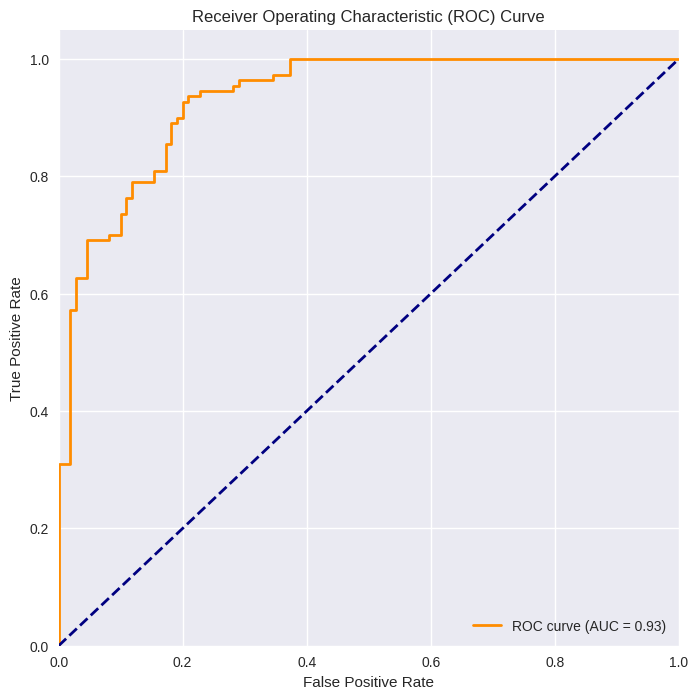


AUC on Test Set: 0.9333


In [44]:
from sklearn.metrics import roc_curve, auc

test_probs = np.exp(test_logits_avg)[:, 1] / np.sum(np.exp(test_logits_avg), axis=1)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, test_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"\nAUC on Test Set: {roc_auc:.4f}")

In [45]:
for i, trainer in enumerate(trainers):
    model_name = id_models[i].replace('/', '_')
    output_dir = f"./saved_model_{model_name}"
    print(f"Saving model {id_models[i]} to {output_dir}")
    trainer.save_model(output_dir)

Saving model indobenchmark/indobert-base-p1 to ./saved_model_indobenchmark_indobert-base-p1
Saving model distilbert-base-multilingual-cased to ./saved_model_distilbert-base-multilingual-cased
Saving model bert-base-multilingual-uncased to ./saved_model_bert-base-multilingual-uncased
